## WCTE_pg_fitter

Here we try to find the 3D geometry of WCTE from labelled images.  The input is the output json files from running the predictor-labeller, or other labelling code.

### JSON Output Structure

This JSON file stores the results of blob–LED matching and camera parameter fitting for a given image.  

#### Example
```json
{
    "image_file": "example.png",
    "fit_parameters": {
        "delta_pitch_deg": 0.15,
        "delta_yaw_deg": -0.05,
        "delta_roll_deg": 0.02,
        "delta_r": 0.01
    },
    "success": true,
    "matches": {
        "043-10": {
            "x": 7278.0,
            "y": 3697.0,
            "size": 12.5,
            "distance": 15.3
        },
        "044-05": {
            "x": 6120.0,
            "y": 2900.0,
            "size": 11.8,
            "distance": 12.7
        }
    }
}
```

#### Top-level fields

- **`image_file`** *(string)*:  
  The basename of the input image file being processed.

- **`fit_parameters`** *(object of floats)*:  
  Dictionary of fitted camera adjustment parameters returned by the optimizer.  
  Keys include:
  - `delta_pitch_deg` – adjustment in pitch (degrees)  
  - `delta_yaw_deg` – adjustment in yaw (degrees)  
  - `delta_roll_deg` – adjustment in roll (degrees)  
  - `delta_r` – radial translation offset  
  - *(any other numeric entries in `fitpars` are also included here)*  

- **`camera_intrinsics`** *(array, shape 3×3)*:  
  The intrinsic calibration matrix `K` of the camera, stored as a nested list.  
  This encodes focal lengths and principal point offsets:
[[fx, 0, cx],
[ 0, fy, cy],
[ 0, 0, 1]]

- **`distortion_coefficients`** *(array)*:  
The fisheye distortion coefficients vector `D`, stored as a list of floats.  
For the OpenCV fisheye model `[k1, k2, k3, k4]`, representing the four radial distortion parameters.

- **`success`** *(boolean)*:  
Indicates whether the optimization converged successfully.

- **`matches`** *(object)*:  
Dictionary mapping each LED label to its matched blob information, with keys being of the form '044-5' with the first numbers in the string being mPMT number and after the dash being LED number:
- `x` *(float)* – x-coordinate of the matched blob in image pixels  
- `y` *(float)* – y-coordinate of the matched blob in image pixels  
- `size` *(float)* – blob size (as detected)  
- `distance` *(float)* – residual distance between blob and simulated projection


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.optimize import minimize
import os
from PredictImage import load_geometry, select_leds
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict


In [2]:
input_image_names = {
    0 : { 'name': 'pch1', 'filename' : 'C:\\Users\\ablai\\Documents\\photogrammetry\\PredictorLabeller\\c1_img20250512-12_06_55CEST.json'},
    1 : { 'name': 'pch2', 'filename' : 'C:\\Users\\ablai\\Documents\\photogrammetry\\PredictorLabeller\\c2_img20250512-12_06_55CEST.json'},
    3 : { 'name': 'pch4', 'filename' : 'C:\\Users\\ablai\\Documents\\photogrammetry\\PredictorLabeller\\c4_img20250512-12_06_55CEST.json'},
    4 : { 'name': 'pch5', 'filename' : 'C:\\Users\\ablai\\Documents\\photogrammetry\\PredictorLabeller\\c5_img20250512-12_06_55CEST.json'},
    5 : { 'name': 'pch6', 'filename' : 'C:\\Users\\ablai\\Documents\\photogrammetry\\PredictorLabeller\\c6_img20250512-12_06_55CEST.json'},
    6 : { 'name': 'pch7', 'filename' : 'C:\\Users\\ablai\\Documents\\photogrammetry\\PredictorLabeller\\c7_img20250512-12_06_55CEST.json'},
    7 : { 'name': 'pch8', 'filename' : 'C:\\Users\\ablai\\Documents\\photogrammetry\\PredictorLabeller\\c8_img20250512-12_06_55CEST.json'}
}



In [3]:
# load design locations and labels to compare
geo = load_geometry("wcte_geometry_file.json")
leds_xyz, labels, num_pmts = select_leds(geo)
# Build a mapping from label -> 3D position
label_to_xyz = {label: xyz for label, xyz in zip(labels, leds_xyz)}

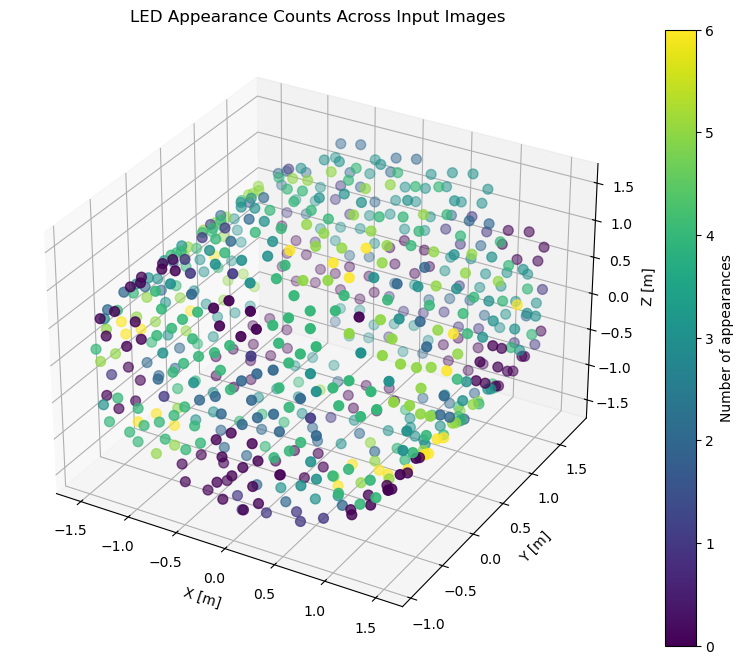

LEDs seen at least 3 times (370):
['021-8', '021-9', '025-6', '025-7', '029-7', '031-6', '031-7', '031-8', '031-9', '031-11', '033-6', '033-7', '033-8', '033-9', '033-10', '033-11', '034-8', '036-8', '036-9', '037-8', '037-9', '037-10', '038-7', '038-8', '038-10', '038-11', '040-6', '040-7', '040-9', '040-10', '041-7', '042-6', '042-7', '042-8', '042-9', '042-10', '042-11', '043-6', '043-7', '043-9', '043-10', '043-11', '044-6', '044-7', '044-8', '044-9', '044-10', '044-11', '046-6', '047-9', '047-10', '047-11', '048-9', '049-6', '049-9', '049-10', '049-11', '050-8', '050-9', '050-10', '051-7', '051-8', '051-10', '051-11', '052-8', '052-9', '052-11', '053-9', '053-10', '058-10', '058-11', '059-7', '059-10', '059-11', '060-6', '060-9', '060-11', '061-11', '062-9', '062-10', '062-11', '064-9', '064-10', '064-11', '065-9', '065-10', '065-11', '066-6', '066-8', '066-9', '066-10', '066-11', '067-9', '067-10', '068-9', '068-10', '069-9', '069-10', '075-6', '075-10', '075-11', '076-10', '076-

In [4]:

# --- Count LED appearances across JSON files ---
appearance_count = defaultdict(int)

for cam_idx, info in input_image_names.items():
    filename = info['filename']
    with open(filename, 'r') as f:
        data = json.load(f)
    for label in data.get('matches', {}).keys():
        if label in label_to_xyz:
            appearance_count[label] += 1

# --- Prepare arrays for plotting ---
plot_xyz = []
plot_counts = []

for label, xyz in label_to_xyz.items():
    plot_xyz.append(xyz)
    plot_counts.append(appearance_count.get(label, 0))

plot_xyz = np.array(plot_xyz)
plot_counts = np.array(plot_counts)

# --- 3D scatter plot ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(plot_xyz[:,0], plot_xyz[:,1], plot_xyz[:,2],
                c=plot_counts, cmap='viridis', s=50)
plt.colorbar(sc, ax=ax, label='Number of appearances')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.set_title('LED Appearance Counts Across Input Images')
plt.show()

# --- List LEDs seen at least 3 times ---
frequent_leds = [label for label, count in appearance_count.items() if count >= 3]
print(f"LEDs seen at least 3 times ({len(frequent_leds)}):")
print(frequent_leds)


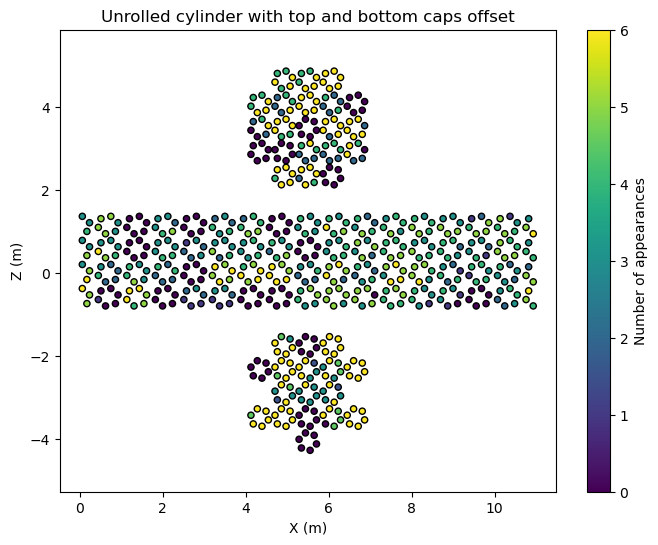

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Cylinder parameters
radius = 3.5/2  # meters
yoffset = 2*1.6  # m vertical offset for top/bottom caps
ycenter = 0.3 #m
xoffset = 2*np.pi*radius / 2 # m

# Extract coordinates
X = plot_xyz[:,0]
Y = plot_xyz[:,1]
Z = plot_xyz[:,2]

# Identify top, bottom, and wall points
Y_top = Y.max()
Y_bottom = Y.min()
is_top = Y == Y_top
is_bottom = Y == Y_bottom
is_wall = ~(is_top | is_bottom)

# Compute perimeter distance for cylinder wall (unrolled)
phi = np.arctan2(Z[is_wall], X[is_wall])
distance_along_perimeter = (phi + np.pi) / (2*np.pi) * (2*np.pi*radius)
X_wall = distance_along_perimeter
Y_wall = Y[is_wall]

# Prepare figure
plt.figure(figsize=(8,6), dpi=100)

# Plot main wall
sc = plt.scatter(X_wall, Y_wall, c=plot_counts[is_wall], s=20, cmap='viridis', edgecolor='k', label='Wall')

# Top cap: X-Z plane offset above wall
X_top = X[is_top] + xoffset
Z_top = Z[is_top] + yoffset + ycenter
plt.scatter(X_top, Z_top, c=plot_counts[is_top], s=20, cmap='viridis', edgecolor='k', label='Top cap')
#for xi, zi, yi_count in zip(X_top, Z_top, plot_counts[is_top]):
#    plt.text(xi, zi, str(int(yi_count)), fontsize=8, ha='center', va='center')

# Bottom cap: X-Z plane offset below wall
X_bottom = X[is_bottom] + xoffset
Z_bottom = Z[is_bottom] - yoffset + ycenter
plt.scatter(X_bottom, Z_bottom, c=plot_counts[is_bottom], s=20, cmap='viridis', edgecolor='k', label='Bottom cap')
#for xi, zi, yi_count in zip(X_bottom, Z_bottom, plot_counts[is_bottom]):
#    plt.text(xi, zi, str(int(yi_count)), fontsize=8, ha='center', va='center')

# Combine all coordinates to determine axis limits
all_x = np.concatenate([X_wall, X_top, X_bottom])
all_y = np.concatenate([Y_wall, Z_top, Z_bottom])  # Y_wall vs Z_top/bottom

plt.xlim(all_x.min() - 0.1, all_x.max() + 0.1)
plt.ylim(all_y.min() - 0.1, all_y.max() + 0.1)

plt.xlabel('X (m)')
plt.ylabel('Z (m)')
plt.title('Unrolled cylinder with top and bottom caps offset')
plt.colorbar(sc, label='Number of appearances')
#plt.grid(alpha=0.3)
plt.axis('equal')
plt.show()


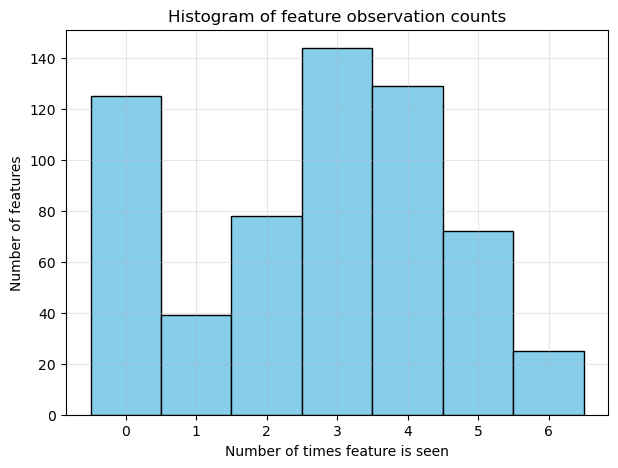

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7,5), dpi=100)
plt.hist(plot_counts, bins=np.arange(plot_counts.min(), plot_counts.max()+2)-0.5,
         color='skyblue', edgecolor='k')
plt.xlabel('Number of times feature is seen')
plt.ylabel('Number of features')
plt.title('Histogram of feature observation counts')
plt.grid(alpha=0.3)
plt.savefig('ntimes_each_feature_seen.png',facecolor='white')
plt.show()


In [7]:
import json
import numpy as np
import cv2
from collections import defaultdict
from scipy.spatial.transform import Rotation as R
from PredictImage import get_camera_orientation

# Example camera intrinsic parameters (replace if per-camera calibration differs)
K = np.array([
    [3253.45225, -3.08866451, 4745.21992],
    [0.0, 3252.26117, 3142.22723],
    [0.0, 0.0, 1.0]
], dtype=np.float64)

D = np.array([0.08330459003495257, 0.008459725805467274,
              0.000681253494528032, 0.0001603712146519313], dtype=np.float64)

points_2d_all = []     # [(x, y), ...] per observation
points_3d_all = []     # [(X, Y, Z), ...] matching design positions
camera_indices = []    # camera index per observation
camera_params = []     # initial extrinsics [rvec, tvec] per camera
#camera_positions = []

# For each camera entry
for cam_idx, info in input_image_names.items():
    filename = info["filename"]
    with open(filename, "r") as f:
        data = json.load(f)
    if not data.get("success", False):
        continue

    # Extract camera fit parameters (in degrees or meters)
    fit = data["fit_parameters"]
    d_pitch = fit.get("delta_pitch_deg", 0)
    d_yaw   = fit.get("delta_yaw_deg", 0)
    d_roll  = fit.get("delta_roll_deg", 0)
    d_r     = fit.get("delta_r", 0)

    # Get design + small deltas
    print('cam_idx=',cam_idx,'pitch=',d_pitch,'yaw=',d_yaw,'roll=',d_roll,'dr=',d_r)
    cam_pos, R_total = get_camera_orientation(
        geo=geo,
        index=cam_idx,
        delta_pitch_deg=d_pitch,
        delta_yaw_deg=d_yaw,
        delta_roll_deg=d_roll,
        delta_r=d_r
    )

    # Convert rotation matrix to rvec for OpenCV / bundle adjustment
    rvec, _ = cv2.Rodrigues(R_total)

    camera_params.append((rvec, cam_pos))
    #camera_positions.append(cam_pos)
    
    
    # Extract matched features
    for label, feat in data.get("matches", {}).items():
        if label not in label_to_xyz:
            continue
        x, y = feat["x"], feat["y"]
        points_2d_all.append([x, y])
        points_3d_all.append(label_to_xyz[label])
        camera_indices.append(cam_idx)


cam_idx= 0 pitch= 15.799231427511403 yaw= -0.7928297638245367 roll= 1.4463795271999862 dr= 0.0656921360571453
cam_idx= 1 pitch= 15.730375263640765 yaw= 0.5680001692325598 roll= 0.16929001653923936 dr= 0.07758070914374532
cam_idx= 3 pitch= 15.755647896673667 yaw= -3.5720226321107895 roll= 3.2549315073754435 dr= 0.08581700251551952
cam_idx= 4 pitch= 0.4501483676574713 yaw= -2.4313853835221764 roll= -4.792947017622175 dr= -0.06824762739447045
cam_idx= 5 pitch= 2.8926352545762177 yaw= 0.2666263247456086 roll= -0.3304384837880916 dr= -0.07077301480477696
cam_idx= 6 pitch= 1.2769860442497525 yaw= 0.4275128579132569 roll= 2.980463238997582 dr= -0.05586324828582002
cam_idx= 7 pitch= 3.5655387002873487 yaw= 4.435388577074878 roll= 1.6054086331702098 dr= -0.10680293602368837


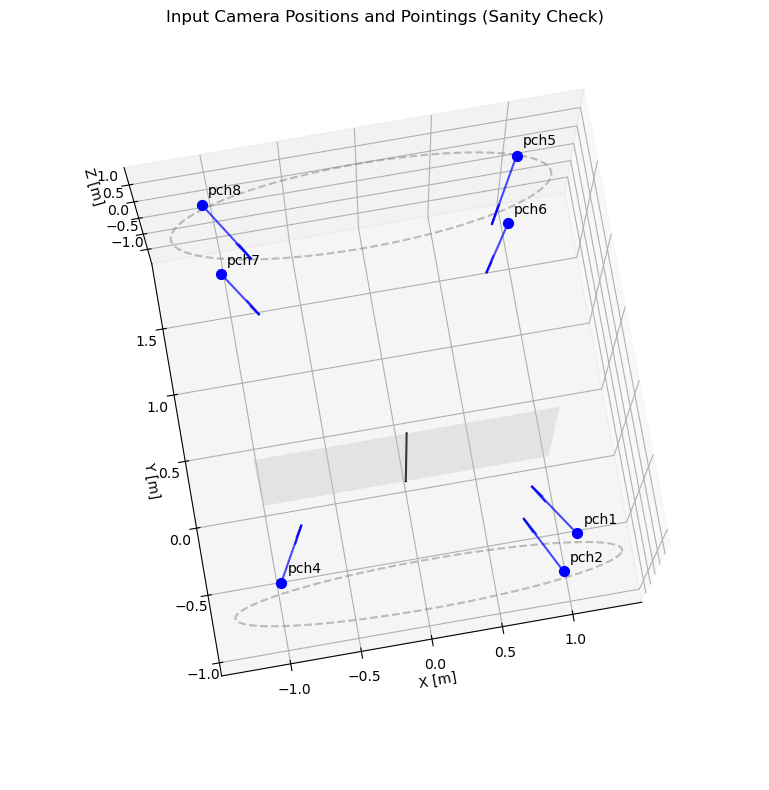

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# Rotate view: Y as vertical
ax.view_init(elev=80, azim=-100)
# Offset for text labels
text_offset = np.array([0.05, 0.05, 0.05])  # in meters

# Cylinder radii and Y positions
cyl_radius = 1.3
y_levels = [-0.9, 1.8]

# Draw reference circles
theta = np.linspace(0, 2*np.pi, 100)
for y in y_levels:
    x_circle = cyl_radius * np.cos(theta)
    z_circle = cyl_radius * np.sin(theta)
    y_circle = np.full_like(x_circle, y)
    ax.plot(x_circle, y_circle, z_circle, color='gray', linestyle='--', alpha=0.5)

# Loop over cameras using input_image_names keys
for cam_idx, (rvec, cam_pos) in zip(input_image_names.keys(), camera_params):
    # Get camera name
    cam_name = input_image_names[cam_idx]['name']
    
    # Convert rvec → rotation matrix
    Rmat, _ = cv2.Rodrigues(rvec)
    dz = Rmat[:, 2]  # optical axis

    # Scatter camera position
    ax.scatter(*cam_pos, c='blue', marker='o', s=50)
    # Draw pointing direction
    ax.quiver(*cam_pos, *dz, length=0.5, color='blue', alpha=0.7)
    # Add label with offset
    ax.text(*(cam_pos + text_offset), cam_name, color='black', fontsize=10)


# Draw the XZ plane at Y=0
xz_plane_size = 1 # adjust as needed
x_plane = np.linspace(-xz_plane_size, xz_plane_size, 2)
z_plane = np.linspace(-xz_plane_size, xz_plane_size, 2)
X_plane, Z_plane = np.meshgrid(x_plane, z_plane)
Y_plane = np.zeros_like(X_plane)  # Y = 0

ax.plot_surface(X_plane, Y_plane, Z_plane, color='lightgrey', alpha=0.3)

# Draw Z axis at Y=0, X=0
z_axis = np.linspace(-xz_plane_size, xz_plane_size, 100)
ax.plot(np.zeros_like(z_axis), np.zeros_like(z_axis), z_axis, color='k', lw=1.5, label='Z axis')

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")

ax.set_title("Input Camera Positions and Pointings (Sanity Check)")
ax.grid(True)
ax.set_box_aspect([1, 1, 1])  # equal aspect ratio
plt.tight_layout()
plt.show()


In [9]:
unique_labels = sorted(set(label for label in label_to_xyz.keys()))
label_to_idx = {label: i for i, label in enumerate(unique_labels)}

# Initialize points3d as a Nx3 array of LED positions
initial_points3d = np.array([label_to_xyz[label] for label in unique_labels])


In [10]:
point_indices = []
points_2d = []
for cam_idx, info in input_image_names.items():
    filename = info["filename"]
    with open(filename, "r") as f:
        data = json.load(f)
    if not data.get("success", False):
        continue
    for label, feat in data.get("matches", {}).items():
        if label not in label_to_idx:
            continue
        x, y = feat["x"], feat["y"]
        point_indices.append(label_to_idx[label])
        points_2d.append([x, y])

points_2d = np.array(points_2d, dtype=float)
camera_indices = np.array(camera_indices, dtype=int)
point_indices = np.array(point_indices, dtype=int)


In [11]:
# --- Prepare dictionaries for per-camera calibration (if all share same K, D) ---
K_per_cam = {cam_idx: K for cam_idx in input_image_names.keys()}
D_per_cam = {cam_idx: D for cam_idx in input_image_names.keys()}

In [12]:
# improved version -- use values from the labelling

K_per_cam = {}
D_per_cam = {}

for cam_idx, info in input_image_names.items():
    filename = info["filename"]
    json_path = filename.replace(".png", ".json")  # or adjust extension as needed
    
    with open(json_path, "r") as f:
        print('opened file:',json_path)
        data = json.load(f)
    
    cam_intr = data["camera_intrinsics"]
    dist = data["distortion_coefficients"]
    
    # camera_intrinsics: expected shape (3x3) possibly stored as nested list or list of lists
    if isinstance(cam_intr, dict):
        # In some formats, keys are "0", "1", "2"
        K = np.array([
            cam_intr["0"],
            cam_intr["1"],
            cam_intr["2"]
        ], dtype=np.float64)
    else:
        K = np.array(cam_intr, dtype=np.float64).reshape(3,3)
    
    D = np.array(dist, dtype=np.float64).reshape(4,1)
    
    K_per_cam[cam_idx] = K
    D_per_cam[cam_idx] = D

print("Loaded per-camera intrinsics for", len(K_per_cam), "cameras")


opened file: C:\Users\ablai\Documents\photogrammetry\PredictorLabeller\c1_img20250512-12_06_55CEST.json
opened file: C:\Users\ablai\Documents\photogrammetry\PredictorLabeller\c2_img20250512-12_06_55CEST.json
opened file: C:\Users\ablai\Documents\photogrammetry\PredictorLabeller\c4_img20250512-12_06_55CEST.json
opened file: C:\Users\ablai\Documents\photogrammetry\PredictorLabeller\c5_img20250512-12_06_55CEST.json
opened file: C:\Users\ablai\Documents\photogrammetry\PredictorLabeller\c6_img20250512-12_06_55CEST.json
opened file: C:\Users\ablai\Documents\photogrammetry\PredictorLabeller\c7_img20250512-12_06_55CEST.json
opened file: C:\Users\ablai\Documents\photogrammetry\PredictorLabeller\c8_img20250512-12_06_55CEST.json
Loaded per-camera intrinsics for 7 cameras


In [13]:
K_per_cam

{0: array([[ 3.25345225e+03, -3.08866451e+00,  4.74521992e+03],
        [ 0.00000000e+00,  3.25226117e+03,  3.14222723e+03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 1: array([[ 3.25345225e+03, -3.08866451e+00,  4.74521992e+03],
        [ 0.00000000e+00,  3.25226117e+03,  3.14222723e+03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 3: array([[ 3.25345225e+03, -3.08866451e+00,  4.74521992e+03],
        [ 0.00000000e+00,  3.25226117e+03,  3.14222723e+03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 4: array([[ 3.25345225e+03, -3.08866451e+00,  4.74521992e+03],
        [ 0.00000000e+00,  3.25226117e+03,  3.14222723e+03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 5: array([[ 3.25345225e+03, -3.08866451e+00,  4.74521992e+03],
        [ 0.00000000e+00,  3.25226117e+03,  3.14222723e+03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 6: array([[ 3.25345225e+03, -3.08866451e+00,  4.74521992e+0

In [14]:
D_per_cam

{0: array([[-0.04880759],
        [ 0.21369394],
        [-0.16525285],
        [ 0.04471981]]),
 1: array([[ 0.11075632],
        [-0.16167188],
        [ 0.16363184],
        [-0.0506917 ]]),
 3: array([[ 0.10277033],
        [-0.13275317],
        [ 0.1235036 ],
        [-0.03490766]]),
 4: array([[ 0.18570052],
        [-0.29230925],
        [ 0.26511817],
        [-0.07627891]]),
 5: array([[ 0.15683392],
        [-0.20609354],
        [ 0.18710675],
        [-0.05573719]]),
 6: array([[ 0.1383324 ],
        [-0.24075809],
        [ 0.25506169],
        [-0.08888099]]),
 7: array([[ 0.01249645],
        [ 0.70500331],
        [-1.15075645],
        [ 0.5747541 ]])}


[Camera 0] rawindex=0, name=pch1, file=C:\Users\ablai\Documents\photogrammetry\PredictorLabeller\c1_img20250512-12_06_55CEST.json


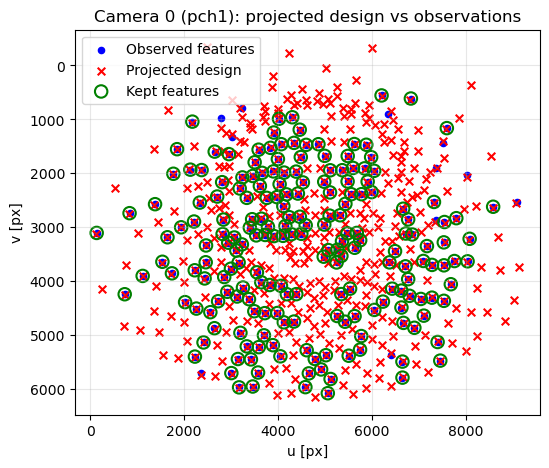

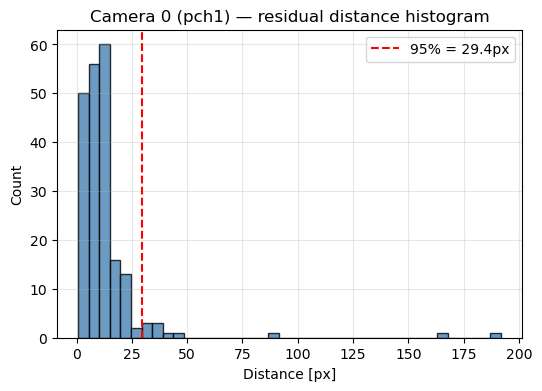

  Median dist: 10.04px, 95th pct cut: 29.41px

[Camera 1] rawindex=1, name=pch2, file=C:\Users\ablai\Documents\photogrammetry\PredictorLabeller\c2_img20250512-12_06_55CEST.json


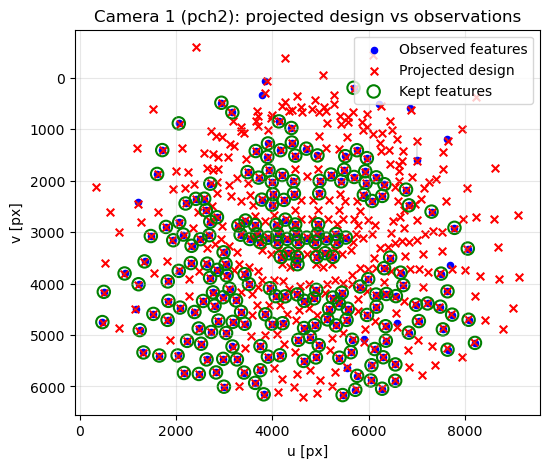

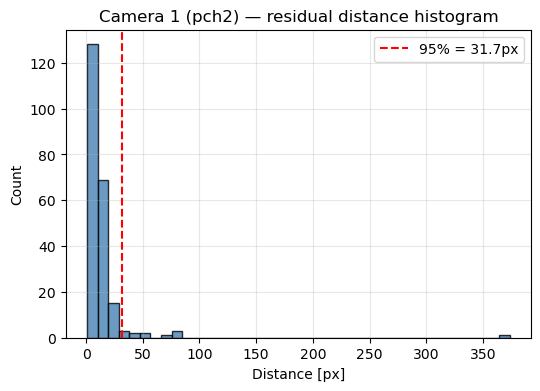

  Median dist: 9.06px, 95th pct cut: 31.69px

[Camera 3] rawindex=2, name=pch4, file=C:\Users\ablai\Documents\photogrammetry\PredictorLabeller\c4_img20250512-12_06_55CEST.json


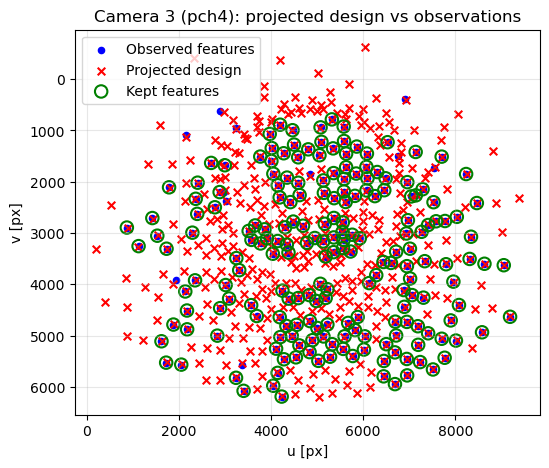

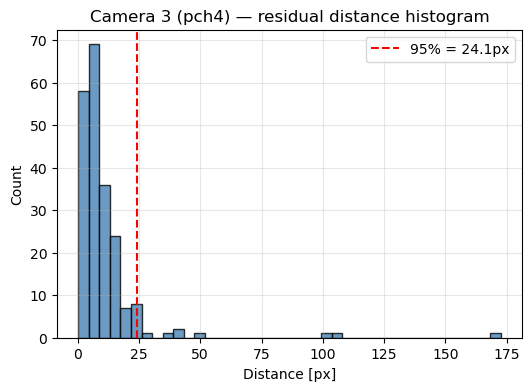

  Median dist: 6.56px, 95th pct cut: 24.08px

[Camera 4] rawindex=3, name=pch5, file=C:\Users\ablai\Documents\photogrammetry\PredictorLabeller\c5_img20250512-12_06_55CEST.json


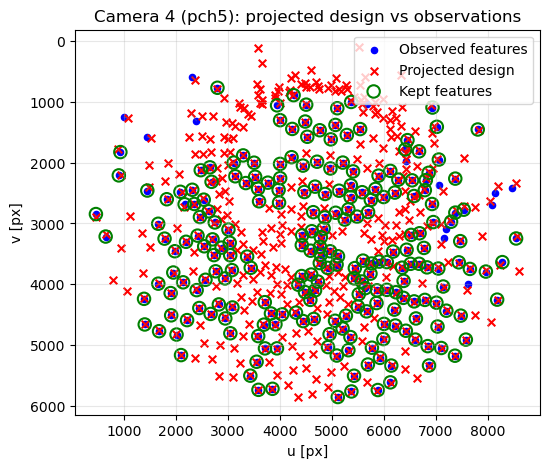

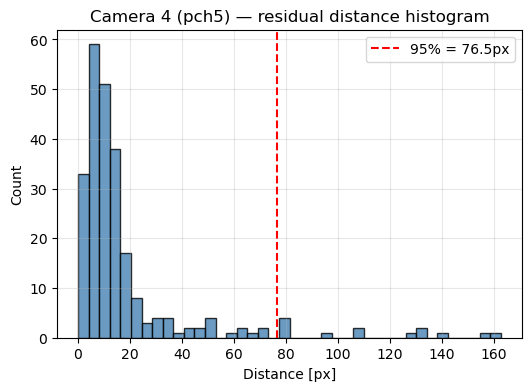

  Median dist: 10.87px, 95th pct cut: 76.50px

[Camera 5] rawindex=4, name=pch6, file=C:\Users\ablai\Documents\photogrammetry\PredictorLabeller\c6_img20250512-12_06_55CEST.json


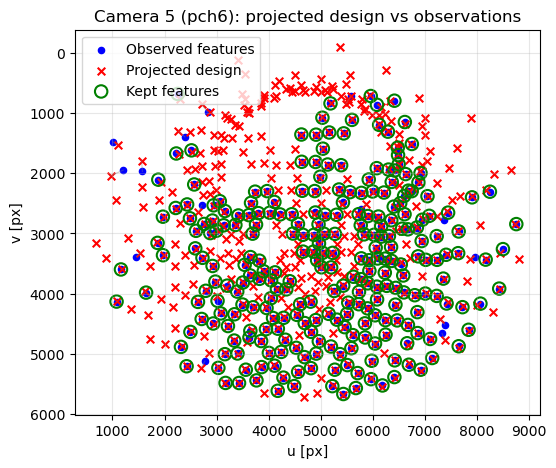

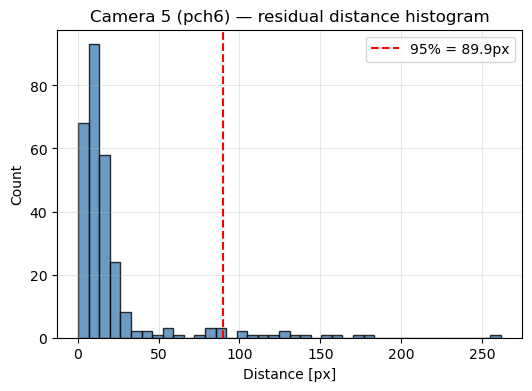

  Median dist: 10.94px, 95th pct cut: 89.89px

[Camera 6] rawindex=5, name=pch7, file=C:\Users\ablai\Documents\photogrammetry\PredictorLabeller\c7_img20250512-12_06_55CEST.json


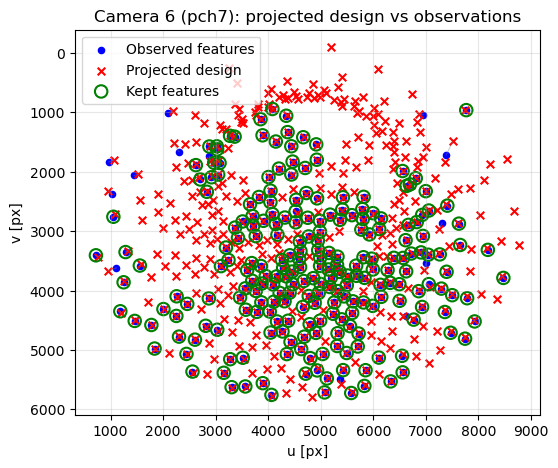

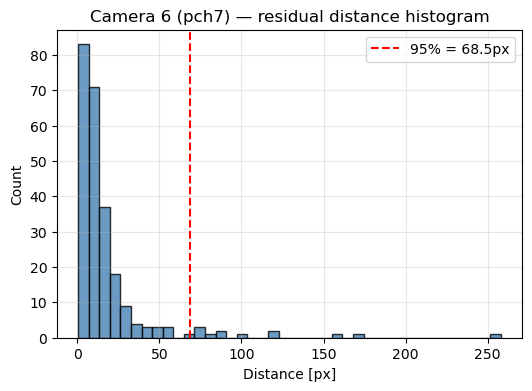

  Median dist: 10.25px, 95th pct cut: 68.49px

[Camera 7] rawindex=6, name=pch8, file=C:\Users\ablai\Documents\photogrammetry\PredictorLabeller\c8_img20250512-12_06_55CEST.json


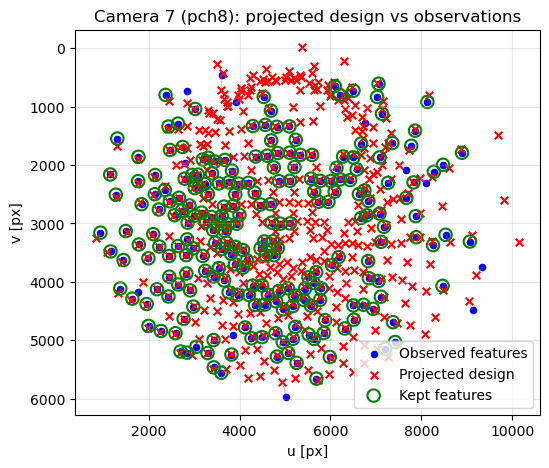

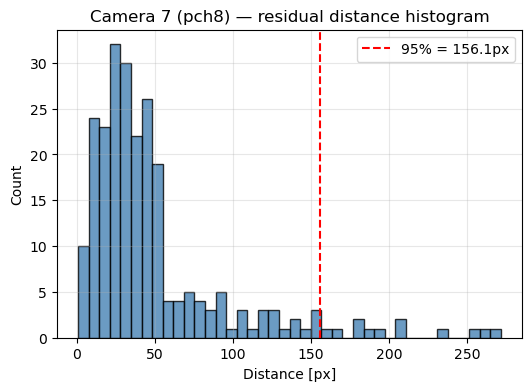

  Median dist: 35.31px, 95th pct cut: 156.10px


In [15]:
from PredictImage import project_leds, get_camera_orientation

# Collect filtered observations for BA
filtered_observations = []

# --- Pre-projection distance check and visualization ---
rawindex = 0
for cam_idx, info in input_image_names.items():
    filename = info["filename"]
    cam_name = info["name"]
    print(f"\n[Camera {cam_idx}] rawindex={rawindex}, name={cam_name}, file={filename}")

    K = K_per_cam[cam_idx]
    D = D_per_cam.get(cam_idx, np.zeros((4,1), dtype=np.float64))
    rvec, cam_pos = camera_params[rawindex]

    # Convert rvec (Rodrigues) to rotation matrix
    R_cam, _ = cv2.Rodrigues(rvec)

    # Apply same y-limit logic as your labeling code
    ylims = (-0.9, 1.8) if cam_idx <= 3 else (-1.1, 1.6)

    # Project LEDs using proven logic
    img_pts, labels_valid = project_leds(
        leds=np.array([label_to_xyz[l] for l in unique_labels]),
        labels=unique_labels,
        cam_pos=cam_pos,
        R_cam=R_cam,
        K=K,
        D=D,
        fov_limit_deg=75.0,
        ylims=ylims,
        excluded_pmts=[]
    )

    # --- Observed features ---
    obs_pts = np.array([[points_2d[i,0], points_2d[i,1]]
                        for i, c_idx in enumerate(camera_indices) if c_idx == cam_idx])
    obs_pt_labels = [unique_labels[point_indices[i]]
                     for i, c_idx in enumerate(camera_indices) if c_idx == cam_idx]

    if len(obs_pts) == 0:
        print(f"[Camera {cam_idx} - {cam_name}] No observations, skipping.")
        rawindex += 1
        continue

    # --- Distance comparison (matching labels) ---
    label_to_proj = {l: img_pts[i] for i, l in enumerate(labels_valid) if i < len(img_pts)}
    matched_dists = []
    matched_obs = []  # keep observation tuples for filtering
    for i, label in enumerate(obs_pt_labels):
        if label in label_to_proj:
            dxdy = label_to_proj[label] - obs_pts[i]
            dist = np.linalg.norm(dxdy)
            matched_dists.append(dist)
            matched_obs.append((cam_idx, label_to_idx[label], obs_pts[i,0], obs_pts[i,1]))

    matched_dists = np.array(matched_dists)
    if len(matched_dists) == 0:
        rawindex += 1
        continue

    # --- Filter using 95th percentile ---
    p95 = np.percentile(matched_dists, 95)
    for dist, obs in zip(matched_dists, matched_obs):
        if dist <= p95:
            filtered_observations.append(obs)

    mask = matched_dists <= p95
    # --- Optional: plotting ---
    plt.figure(figsize=(6,5),dpi=100)
    plt.scatter(obs_pts[:,0], obs_pts[:,1], c='blue', label='Observed features', s=20)
    if len(img_pts):
        plt.scatter(img_pts[:,0], img_pts[:,1], c='red', marker='x', label='Projected design', s=30)
        for i, label in enumerate(obs_pt_labels):
            if label in label_to_proj:
                proj_pt = label_to_proj[label]
                obs_pt = obs_pts[i]
                plt.plot([obs_pt[0], proj_pt[0]], [obs_pt[1], proj_pt[1]],
                         color='gray', alpha=0.4, linewidth=0.8)
         # --- Highlight kept points ---
        kept_obs_pts = obs_pts[mask]
        plt.scatter(kept_obs_pts[:,0], kept_obs_pts[:,1], facecolors='none', edgecolors='green',
                s=80, linewidths=1.5, label='Kept features')
    plt.title(f"Camera {cam_idx} ({cam_name}): projected design vs observations")
    plt.xlabel("u [px]")
    plt.ylabel("v [px]")
    plt.legend()
    plt.gca().invert_yaxis()
    plt.grid(alpha=0.3)
    plt.savefig('features_matched'+str(cam_name)+'.png',facecolor='white')
    plt.show()

    # --- Histogram of residual distances ---
    plt.figure(figsize=(6,4),dpi=100)
    plt.hist(matched_dists, bins=40, color='steelblue', edgecolor='black', alpha=0.8)
    plt.axvline(p95, color='red', linestyle='--', label=f"95% = {p95:.1f}px")
    plt.title(f"Camera {cam_idx} ({cam_name}) — residual distance histogram")
    plt.xlabel("Distance [px]")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig('features_residuals'+str(cam_name)+'.png',facecolor='white')
    plt.show()

    print(f"  Median dist: {np.median(matched_dists):.2f}px, 95th pct cut: {p95:.2f}px")

    rawindex += 1




In [16]:
# --- Build filtered arrays for bundle adjustment ---
filtered_points_2d = []
filtered_camera_indices = []
filtered_point_indices = []

for cam_idx, point_idx, u, v in filtered_observations:
    filtered_camera_indices.append(cam_idx)
    filtered_point_indices.append(point_idx)
    filtered_points_2d.append([u, v])

filtered_points_2d = np.array(filtered_points_2d, dtype=float)
filtered_camera_indices = np.array(filtered_camera_indices, dtype=int)
filtered_point_indices = np.array(filtered_point_indices, dtype=int)

# Create filtered initial_points3d: just keep all design points (or initial guesses)
# if you want to remove unobserved points entirely, you can filter by unique(filtered_point_indices)
filtered_initial_points3d = initial_points3d.copy()  # or only points that survived filtering




In [17]:
import numpy as np
import matplotlib.pyplot as plt
from PredictImage import project_leds  # make sure you use your fisheye projection function

# -----------------------------
# Step 1: Build initial_camera_poses
# -----------------------------
initial_camera_poses = {}
for rawindex, (cam_idx, info) in enumerate(input_image_names.items()):
    rvec, cam_pos = camera_params[rawindex]
    initial_camera_poses[cam_idx] = (np.asarray(rvec).ravel(), np.asarray(cam_pos).ravel())

# -----------------------------
# Step 2: Identify points used in filtered_observations
# -----------------------------
used_point_indices = sorted({int(obs[1]) for obs in filtered_observations})  # make sure indices are ints
point_index_map = {old_idx: new_idx for new_idx, old_idx in enumerate(used_point_indices)}

# -----------------------------
# Step 3: Build compact filtered 3D points array
# -----------------------------
filtered_initial_points3d = np.zeros((len(used_point_indices), 3), dtype=float)
for old_idx, new_idx in point_index_map.items():
    filtered_initial_points3d[new_idx] = initial_points3d[old_idx]

# -----------------------------
# Step 4: Build compact filtered observations with remapped point indices
# -----------------------------
filtered_observations_compact = [
    (int(cam_idx), int(point_index_map[int(pt_idx)]), float(u), float(v))
    for cam_idx, pt_idx, u, v in filtered_observations
]

# -----------------------------
# Step 5: Build compact label -> xyz mapping for design points
# -----------------------------
filtered_labels = [labels[i] for i in used_point_indices]
label_to_xyz_design_compact = {l: label_to_xyz[l] for l in filtered_labels}

# -----------------------------
# Step 6: Sanity checks
# -----------------------------
print(f"Number of cameras: {len(initial_camera_poses)}")
print(f"Number of filtered points: {filtered_initial_points3d.shape[0]}")
print(f"Number of filtered observations: {len(filtered_observations_compact)}")
print(f"First 5 filtered obs: {filtered_observations_compact[:5]}")
print(f"First 5 filtered points3d:\n{filtered_initial_points3d[:5]}")

# Make mapping: label -> compact index for plotting
label_to_compact_idx = {l: i for i, l in enumerate(filtered_labels)}


Number of cameras: 7
Number of filtered points: 486
Number of filtered observations: 1567
First 5 filtered obs: [(0, 81, 840.1046752929688, 2739.22802734375), (0, 82, 140.21026611328125, 3105.5361328125), (0, 103, 8579.3505859375, 2619.933837890625), (0, 108, 7397.2197265625, 5128.31640625), (0, 107, 7454.08056640625, 5473.7451171875)]
First 5 filtered points3d:
[[ 0.05617632 -0.93040806 -0.20965312]
 [-0.15347677 -0.93040806 -0.15347668]
 [-0.20965309 -0.93040806  0.05617644]
 [-0.05617632 -0.93040806  0.20965312]
 [ 0.15347677 -0.93040806  0.15347668]]


Number of cameras: 7
Number of filtered points: 486
Number of filtered observations: 1567
cam_idx= 0 rvec= [-2.0767714   0.45158022  0.89408937] cam_pos= [ 0.96121626 -0.85324353  0.9624532 ] D= [[-0.04880759]
 [ 0.21369394]
 [-0.16525285]
 [ 0.04471981]]


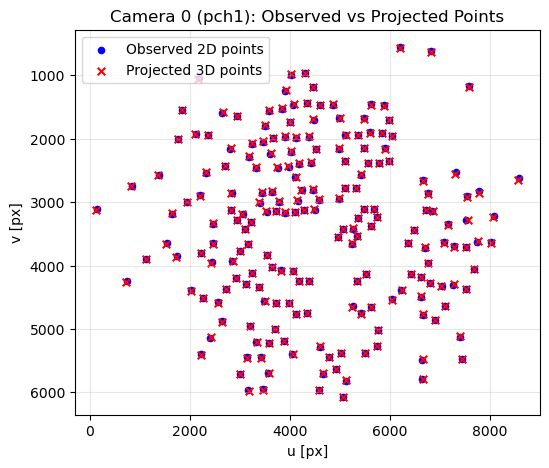

cam_idx= 1 rvec= [-0.98717884  1.16711845  2.35189985] cam_pos= [ 0.95615973 -0.84384548 -0.95720664] D= [[ 0.11075632]
 [-0.16167188]
 [ 0.16363184]
 [-0.0506917 ]]


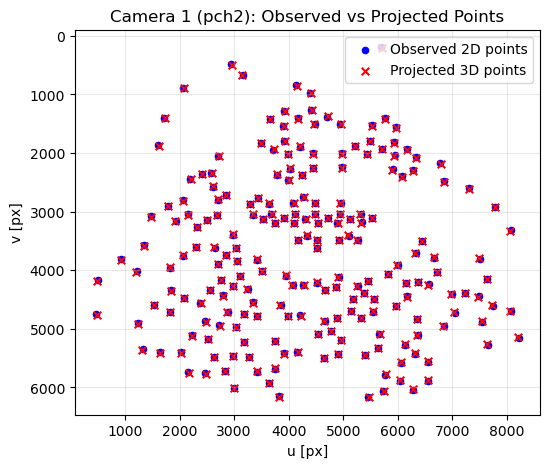

cam_idx= 3 rvec= [-2.11970978 -0.37897589 -0.76056332] cam_pos= [-0.95689449 -0.83737349  0.94961724] D= [[ 0.10277033]
 [-0.13275317]
 [ 0.1235036 ]
 [-0.03490766]]


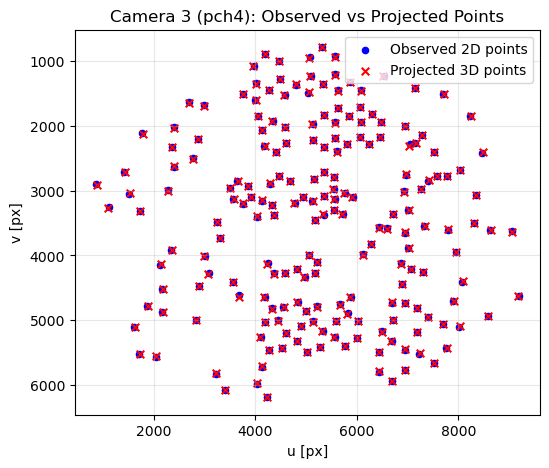

cam_idx= 4 rvec= [ 0.49879706 -2.07884161  1.0177313 ] cam_pos= [1.02127877 1.73922534 1.01718437] D= [[ 0.18570052]
 [-0.29230925]
 [ 0.26511817]
 [-0.07627891]]


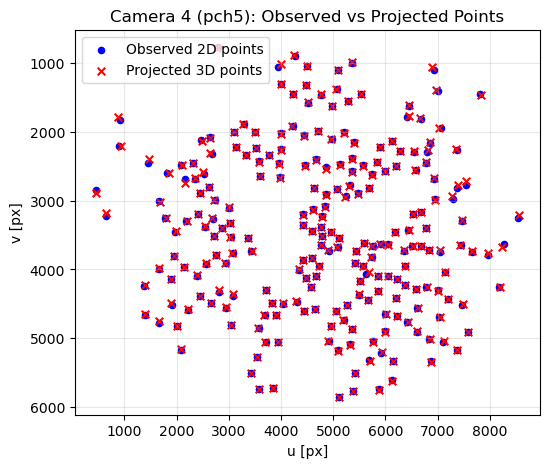

cam_idx= 5 rvec= [ 0.8332169  -0.73511132  0.33664347] cam_pos= [ 1.02224101  1.73940251 -1.02177584] D= [[ 0.15683392]
 [-0.20609354]
 [ 0.18710675]
 [-0.05573719]]


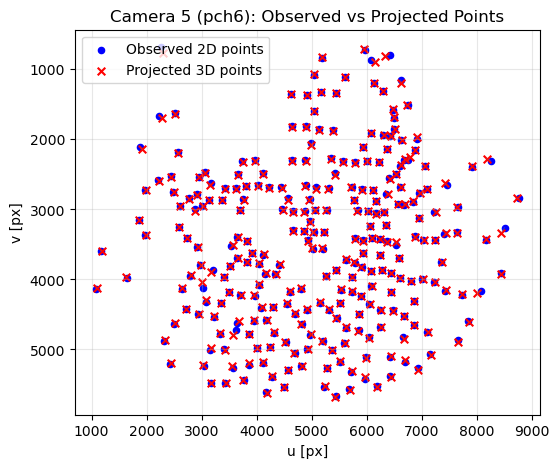

cam_idx= 6 rvec= [ 0.8721689   0.69961112 -0.31158059] cam_pos= [-1.01410398  1.7289311  -1.0146933 ] D= [[ 0.1383324 ]
 [-0.24075809]
 [ 0.25506169]
 [-0.08888099]]


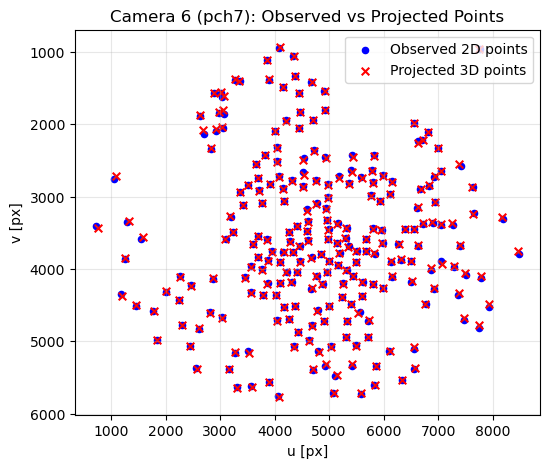

cam_idx= 7 rvec= [ 0.39467357  2.09761697 -0.99053639] cam_pos= [-1.04467624  1.76603595  1.03301803] D= [[ 0.01249645]
 [ 0.70500331]
 [-1.15075645]
 [ 0.5747541 ]]


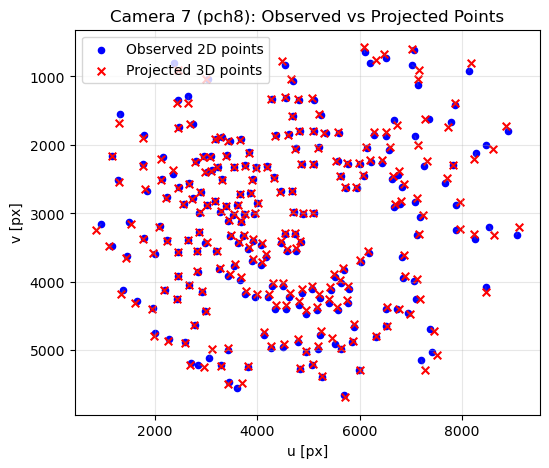

In [18]:
from bundle_fisheye_ba import project_points_fisheye_ba


# --- compact index -> 3D coordinates ---
compact_idx_to_3d = {i: filtered_initial_points3d[i] for i in range(len(filtered_initial_points3d))}

# --- label -> compact index ---
label_to_compact_idx = {l: i for i, l in enumerate(filtered_labels)}

print(f"Number of cameras: {len(initial_camera_poses)}")
print(f"Number of filtered points: {len(filtered_initial_points3d)}")
print(f"Number of filtered observations: {len(filtered_observations_compact)}")

# --- Loop over cameras ---
for cam_idx, info in input_image_names.items():
    filename = info["filename"]
    cam_name = info["name"]

    rvec, cam_pos = initial_camera_poses[cam_idx]
    rvec = np.asarray(rvec).ravel()
    cam_pos = np.asarray(cam_pos).ravel()

    # --- Observations for this camera ---
    obs_cam = [obs for obs in filtered_observations_compact if obs[0] == cam_idx]
    if len(obs_cam) == 0:
        print(f"[Camera {cam_idx} - {cam_name}] No observations, skipping.")
        continue

    obs_pt_indices = [obs[1] for obs in obs_cam]
    obs_pts = np.array([[obs[2], obs[3]] for obs in obs_cam], dtype=float)
    obs_labels = [filtered_labels[i] for i in obs_pt_indices]

    # --- Filtered 3D points ---
    filtered_pts3d = np.array([compact_idx_to_3d[i] for i in obs_pt_indices])

    # --- Intrinsics ---
    K = K_per_cam[cam_idx]
    D = D_per_cam.get(cam_idx, np.zeros((4,1), dtype=np.float64))


    # --- Use project_points_fisheye_ba exactly ---
    # For testing, we override the FOV and ylims to effectively disable filtering
    print('cam_idx=',cam_idx,'rvec=',rvec,'cam_pos=',cam_pos,'D=',D)
    img_pts, valid_mask = project_points_fisheye_ba(
        points3d=filtered_pts3d,
        rvec=rvec,
        cam_pos=cam_pos,
        K=K,
        D=D,
        fov_limit_deg=180.0,   # very wide to include all points
        ylims=(-1e6, 1e6)      # huge vertical range to keep all points
    )

    # valid_mask should now be all True
    assert img_pts.shape[0] == filtered_pts3d.shape[0], "Mismatch in projected points count"

    # --- Plot as before ---
    plt.figure(figsize=(6,5))
    plt.scatter(obs_pts[:,0], obs_pts[:,1], c='blue', label='Observed 2D points', s=20)
    plt.scatter(img_pts[:,0], img_pts[:,1], c='red', marker='x', label='Projected 3D points', s=30)
    for i in range(len(obs_pts)):
        plt.plot([obs_pts[i,0], img_pts[i,0]], [obs_pts[i,1], img_pts[i,1]], color='gray', alpha=0.3, linewidth=0.8)
    plt.title(f"Camera {cam_idx} ({cam_name}): Observed vs Projected Points")
    plt.xlabel("u [px]")
    plt.ylabel("v [px]")
    plt.gca().invert_yaxis()
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()



In [19]:
from bundle_fisheye_ba import run_bundle_adjustment_filtered
import numpy as np
import time

# -----------------------------
# Step 6: Run bundle adjustment
# -----------------------------
t0 = time.time()
ba_results = run_bundle_adjustment_filtered(
    input_image_names=input_image_names,
    label_to_xyz_design=label_to_xyz_design_compact,
    filtered_observations=filtered_observations_compact,
    initial_camera_poses=initial_camera_poses,
    initial_points3d=filtered_initial_points3d,
    K_per_cam=K_per_cam,
    D_per_cam=D_per_cam,
    method='trf',
    verbose=True
)
t1 = time.time()

print(f"Bundle adjustment took {t1 - t0:.1f} s")
print(f"Final RMSE (pixels): {ba_results['rmse_pixels']:.2f}")

# -----------------------------
# Step 7: Optional: inspect first few residuals
# -----------------------------
residuals = np.array(ba_results['res'].fun).reshape(-1, 2)
for i, res_uv in enumerate(residuals[:10]):
    print(f"Obs {i}: du={res_uv[0]:.2f}, dv={res_uv[1]:.2f}")

#cam_idx= 0 rvec= [-2.0767714   0.45158022  0.89408937] cam_pos= [ 0.96121626 -0.85324353  0.9624532 ] D= [[-0.04880759]
# [ 0.21369394]
# [-0.16525285]
# [ 0.04471981]] ... [-0.9872  1.1671  2.3519]

call count= 0
summary= {'mean_delta_m': 0.00946625692918029, 'median_delta_m': 0.0, 'max_delta_m': 0.37593966532626466, 'rmse_pixels': None, 'n_points': 486, 'n_cameras': 7}
Results saved to bundle_adjustment_at_call_0.json
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.0668e+04                                    8.71e+03    
       1              4         2.6026e+04      4.64e+03       4.28e-02       1.31e+04    
       2              5         2.3971e+04      2.06e+03       4.58e-02       1.31e+04    
       3              7         2.2644e+04      1.33e+03       1.04e-02       1.03e+04    
       4              8         2.1768e+04      8.76e+02       1.14e-02       6.07e+03    
       5              9         2.1124e+04      6.43e+02       1.16e-02       4.37e+03    
       6             10         2.0346e+04      7.79e+02       2.33e-02       5.40e+03    
       7             11         1.9724e+04      

In [20]:
import scipy
print(scipy.__version__)
from scipy.optimize import least_squares
help(least_squares)

1.16.0
Help on function least_squares in module scipy.optimize._lsq.least_squares:

least_squares(
    fun,
    x0,
    jac='2-point',
    bounds=(-inf, inf),
    method='trf',
    ftol=1e-08,
    xtol=1e-08,
    gtol=1e-08,
    x_scale=None,
    loss='linear',
    f_scale=1.0,
    diff_step=None,
    tr_solver=None,
    tr_options=None,
    jac_sparsity=None,
    max_nfev=None,
    verbose=0,
    args=(),
    kwargs=None,
    callback=None,
    workers=None
)
    Solve a nonlinear least-squares problem with bounds on the variables.

    Given the residuals f(x) (an m-D real function of n real
    variables) and the loss function rho(s) (a scalar function), `least_squares`
    finds a local minimum of the cost function F(x)::

        minimize F(x) = 0.5 * sum(rho(f_i(x)**2), i = 0, ..., m - 1)
        subject to lb <= x <= ub

    The purpose of the loss function rho(s) is to reduce the influence of
    outliers on the solution.

    Parameters
    ----------
    fun : callable
      

In [21]:
print('x' in locals(), 'res' in locals(), 'res' in globals())
print(type(x))

True False False
<class 'float'>


In [22]:
# Diagnostic comparer: PredictImage.project_leds vs project_points_fisheye_ba
import numpy as np
import cv2
from collections import defaultdict
from PredictImage import project_leds
from bundle_fisheye_ba import project_points_fisheye_ba   # your BA wrapper
import math

# Group observations by camera (from compact filtered observations)
obs_by_cam = defaultdict(list)
for cam_idx, pt_idx, u, v in filtered_observations_compact:
    obs_by_cam[cam_idx].append((pt_idx, float(u), float(v)))

def analyze_camera(cam_idx, try_cam_pos_from_tvec=False):
    info = input_image_names.get(cam_idx, {})
    cam_name = info.get("name", str(cam_idx))
    print(f"\n--- Camera {cam_idx} ({cam_name})  --- try_cam_pos_from_tvec={try_cam_pos_from_tvec}")

    # get extrinsics from your initial_camera_poses mapping
    if cam_idx not in initial_camera_poses:
        print("  WARNING: cam_idx not in initial_camera_poses")
        return

    rvec, second = initial_camera_poses[cam_idx]
    rvec = np.asarray(rvec).ravel()
    # decide cam_pos convention
    R_cam, _ = cv2.Rodrigues(rvec)
    if try_cam_pos_from_tvec:
        # interpret second as tvec (world->cam translation) -> camera position in world = -R.T @ tvec
        tvec = np.asarray(second).ravel()
        cam_pos = (-R_cam.T) @ tvec
    else:
        # interpret second as camera world position directly
        cam_pos = np.asarray(second).ravel()

    K = K_per_cam[cam_idx]
    D = D_per_cam.get(cam_idx, np.zeros((4,1), dtype=np.float64))

    obs_cam = obs_by_cam.get(cam_idx, [])
    if len(obs_cam) == 0:
        print("  No observations for this camera.")
        return

    obs_point_indices = [pt_idx for pt_idx, _, _ in obs_cam]
    obs_uv = np.array([[u, v] for _, u, v in obs_cam], dtype=float)
    obs_labels = [filtered_labels[i] for i in obs_point_indices]
    pts3d_world = np.array([filtered_initial_points3d[i] for i in obs_point_indices], dtype=float)

    # 1) project using PredictImage.project_leds (the working code)
    img_pts_leds, labels_valid_leds = project_leds(
        leds=pts3d_world,
        labels=obs_labels,
        cam_pos=cam_pos,
        R_cam=R_cam,
        K=K,
        D=D,
        fov_limit_deg=180.0,   # keep wide for diagnostics
        ylims=(-1.1, 1.9),
        excluded_pmts=[]
    )
    img_pts_leds = np.asarray(img_pts_leds)
    n_leds_valid = len(labels_valid_leds)

    # 2) project using BA wrapper
    proj_ba, mask_ba = project_points_fisheye_ba(
        points3d=pts3d_world,
        rvec=rvec,
        cam_pos=cam_pos,
        K=K,
        D=D,
        fov_limit_deg=180.0,
        ylims=(-1.1, 1.9)
    )
    proj_ba = np.asarray(proj_ba)
    mask_ba = np.asarray(mask_ba, dtype=bool)
    n_ba_valid = int(mask_ba.sum())

    print(f"  Observations for this camera: {len(obs_cam)}")
    print(f"  project_leds valid count = {n_leds_valid}")
    print(f"  project_points_fisheye_ba valid count = {n_ba_valid}")

    # Quick check: camera-frame coordinates & angles for first few points (before any filtering)
    xyz_cam = (R_cam.T @ (pts3d_world - cam_pos).T).T   # world->cam frame as in project_leds
    zs = xyz_cam[:,2]
    angles = np.degrees(np.arccos(np.clip(xyz_cam[:,2] / (np.linalg.norm(xyz_cam, axis=1)+1e-12), -1.0, 1.0)))
    print("  sample camera-frame z (first 10):", np.round(zs[:10], 4))
    print("  sample angles to optical axis (deg, first 10):", np.round(angles[:10], 2))

    # show how many points are behind camera or out of y-limits
    behind = (zs <= 0).sum()
    ylims = (-0.9, 1.8) if cam_idx <= 3 else (-1.1, 1.6)
    out_y = ((pts3d_world[:,1] < ylims[0]) | (pts3d_world[:,1] > ylims[1])).sum()
    print(f"  Behind camera (z<=0): {behind}/{len(pts3d_world)}")
    print(f"  Outside y-lims {ylims}: {out_y}/{len(pts3d_world)}")

    # Compare per-observation difference between the two projection outputs (where both produced something)
    # Build a mapping from label -> projected coordinate for project_leds
    led_map = {lbl: img_pts_leds[i] for i, lbl in enumerate(labels_valid_leds)}
    # For BA wrapper, it returns array same order as input points, with NaNs where invalid. So compare directly.
    both_idxs = []
    diffs = []
    for i, lbl in enumerate(obs_labels):
        a = led_map.get(lbl, None)
        b = None
        if mask_ba[i]:
            b = proj_ba[i]
        if a is not None and (b is not None):
            both_idxs.append(i)
            diffs.append(np.linalg.norm(np.asarray(a)-np.asarray(b)))
    if len(diffs) > 0:
        diffs = np.array(diffs)
        print(f"  Comparison (where both valid): count={len(diffs)}, mean dist = {diffs.mean():.2f}px, median={np.median(diffs):.2f}px, max={diffs.max():.2f}px")
    else:
        print("  No points projected by both methods for direct comparison.")

    # Print a few example per-observation rows to inspect
    print("\n  Example rows (obs_idx, label, obs_uv, proj_leds(if any), proj_ba(if any)):")
    rows = min(10, len(obs_labels))
    for i in range(rows):
        lbl = obs_labels[i]
        led_val = led_map.get(lbl, None)
        ba_val = proj_ba[i] if mask_ba[i] else None
        print(f"   {i:3d}  {lbl:10s}  obs={obs_uv[i]}  leds={led_val}  ba={ba_val}")

# Run analysis for every camera using both conventions quickly
for cam_idx in sorted(obs_by_cam.keys()):
    analyze_camera(cam_idx, try_cam_pos_from_tvec=False)
    analyze_camera(cam_idx, try_cam_pos_from_tvec=True)



--- Camera 0 (pch1)  --- try_cam_pos_from_tvec=False
  Observations for this camera: 197
  project_leds valid count = 197
  project_points_fisheye_ba valid count = 197
  sample camera-frame z (first 10): [0.4527 0.2614 0.5121 1.3057 1.1707 1.6389 1.4968 2.0152 2.1393 2.0974]
  sample angles to optical axis (deg, first 10): [65.19 74.37 64.2  55.95 59.94 51.45 55.29 46.41 43.24 44.32]
  Behind camera (z<=0): 0/197
  Outside y-lims (-0.9, 1.8): 0/197
  Comparison (where both valid): count=197, mean dist = 0.00px, median=0.00px, max=0.00px

  Example rows (obs_idx, label, obs_uv, proj_leds(if any), proj_ba(if any)):
     0  021-10      obs=[ 840.10467529 2739.22802734]  leds=[ 834.32208388 2745.3806371 ]  ba=[ 834.32208388 2745.3806371 ]
     1  021-11      obs=[ 140.21026611 3105.53613281]  leds=[ 123.93786997 3120.22475574]  ba=[ 123.93786997 3120.22475574]
     2  025-9       obs=[8579.35058594 2619.93383789]  leds=[8575.96442935 2642.97077997]  ba=[8575.96442935 2642.97077997]
     3

IndexError: boolean index did not match indexed array along axis 0; size of axis is 197 but size of corresponding boolean axis is 170

In [ ]:
# --- Comparison test between reference projection and BA projection ---
dummy_labels = [f"{i}-0" for i in range(len(filtered_pts3d))]


proj_ref, _ = project_leds(
    leds=filtered_pts3d,
    labels=dummy_labels,  
    cam_pos=cam_pos,
    R_cam=R_cam,
    K=K,
    D=D,
    fov_limit_deg=180.0,  # disable FOV clipping for reference
    ylims=(-1.1, 1.9),    # or whatever range fits this camera
    excluded_pmts=[]
)

proj_ba, valid_mask_ba = project_points_fisheye_ba(
    points3d=filtered_pts3d,
    rvec=rvec,
    cam_pos=cam_pos,  # make sure the variable names match what the function expects
    K=K,
    D=D,
    fov_limit_deg=180.0,
    ylims=(-1.1,1.9)
)

print("Total points:", len(filtered_pts3d))
print("Valid (ref):", np.isfinite(proj_ref).all(axis=1).sum())
print("Valid (BA): ", valid_mask_ba.sum())
print("Dropped points (BA):", (~valid_mask_ba).sum())

bad_indices = np.where(~valid_mask_ba)[0]
print("Example dropped indices:", bad_indices[:10])


In [ ]:
from scipy.optimize import OptimizeResult  

def make_json_safe(obj):
    """Recursively convert any NumPy/scipy object into JSON-safe types."""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64, np.int32, np.int64)):
        return float(obj)
    elif isinstance(obj, OptimizeResult):
        return {k: make_json_safe(v) for k, v in obj.__dict__.items()}
    elif isinstance(obj, dict):
        return {str(k): make_json_safe(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [make_json_safe(v) for v in obj]
    elif hasattr(obj, '__dict__'):
        # Fallback for objects with attributes
        return {k: make_json_safe(v) for k, v in obj.__dict__.items()}
    else:
        try:
            json.dumps(obj)
            return obj
        except TypeError:
            return str(obj)

# Convert results for JSON
#ba_results_jsonsafe = make_json_safe(ba_results)

#outname = "bundle_adjustment_results.json"
#with open(outname, "w") as f:
#    json.dump(ba_results_jsonsafe, f, indent=2)

#print(f"Results saved to {outname}")

=== Bundle Adjustment Summary ===
RMS deviation from design: 52.52 mm
Mean delta:   22.15 mm
Median delta: 10.81 mm
Max delta:    441.90 mm
RMSE (pixels): 12.319289185878889
Points: 486, Cameras: 7


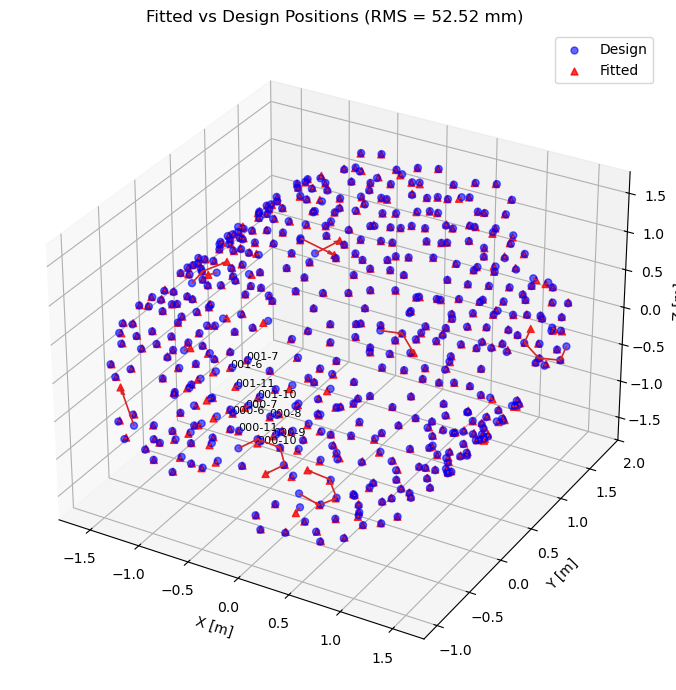

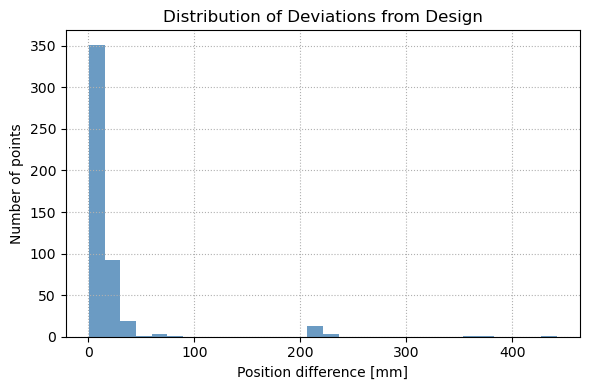

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# --- Extract fitted vs. design points from results ---
points_dict = ba_results["points"]
summary = ba_results.get("summary", {})

labels = list(points_dict.keys())
design_points = np.array([points_dict[l]["design_xyz"] for l in labels])
fitted_points = np.array([points_dict[l]["fitted_xyz"] for l in labels])

# Compute differences
diff = fitted_points - design_points
diff_norms = np.linalg.norm(diff, axis=1)
rms = np.sqrt(np.mean(np.sum(diff**2, axis=1)))

# --- Print summary ---
print("=== Bundle Adjustment Summary ===")
print(f"RMS deviation from design: {rms*1000:.2f} mm")
print(f"Mean delta:   {summary.get('mean_delta_m', np.mean(diff_norms))*1000:.2f} mm")
print(f"Median delta: {summary.get('median_delta_m', np.median(diff_norms))*1000:.2f} mm")
print(f"Max delta:    {summary.get('max_delta_m', np.max(diff_norms))*1000:.2f} mm")
print(f"RMSE (pixels): {summary.get('rmse_pixels', 'N/A')}")
print(f"Points: {summary.get('n_points', len(labels))}, Cameras: {summary.get('n_cameras', 'N/A')}")
print("=================================")

# --- 3D visualization ---
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

# Draw arrows showing movement from design → fitted
ax.quiver(
    design_points[:, 0], design_points[:, 1], design_points[:, 2],
    diff[:, 0], diff[:, 1], diff[:, 2],
    color='tab:red', arrow_length_ratio=0.2, linewidth=1.2, normalize=False
)

# Scatter start and end points
ax.scatter(design_points[:, 0], design_points[:, 1], design_points[:, 2],
           c='blue', label='Design', s=25, alpha=0.6)
ax.scatter(fitted_points[:, 0], fitted_points[:, 1], fitted_points[:, 2],
           c='red', label='Fitted', s=25, marker='^', alpha=0.8)

# Optionally annotate a few points
for i, l in enumerate(labels[:10]):  # label first 10 points
    ax.text(fitted_points[i,0], fitted_points[i,1], fitted_points[i,2], l, fontsize=8)

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.set_title(f"Fitted vs Design Positions (RMS = {rms*1000:.2f} mm)")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

# --- 2D histogram of point residual magnitudes ---
plt.figure(figsize=(6, 4))
plt.hist(diff_norms*1000, bins=30, color='steelblue', alpha=0.8)
plt.xlabel("Position difference [mm]")
plt.ylabel("Number of points")
plt.title("Distribution of Deviations from Design")
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()



In [24]:
def rvec_to_direction(rvec):
    """Convert rotation vector to unit pointing vector in world coordinates."""
    R, _ = cv2.Rodrigues(np.array(rvec))
    # Camera optical axis in local coordinates is (0,0,1)
    dir_vec = R @ np.array([0, 0, 1])
    return dir_vec / np.linalg.norm(dir_vec)

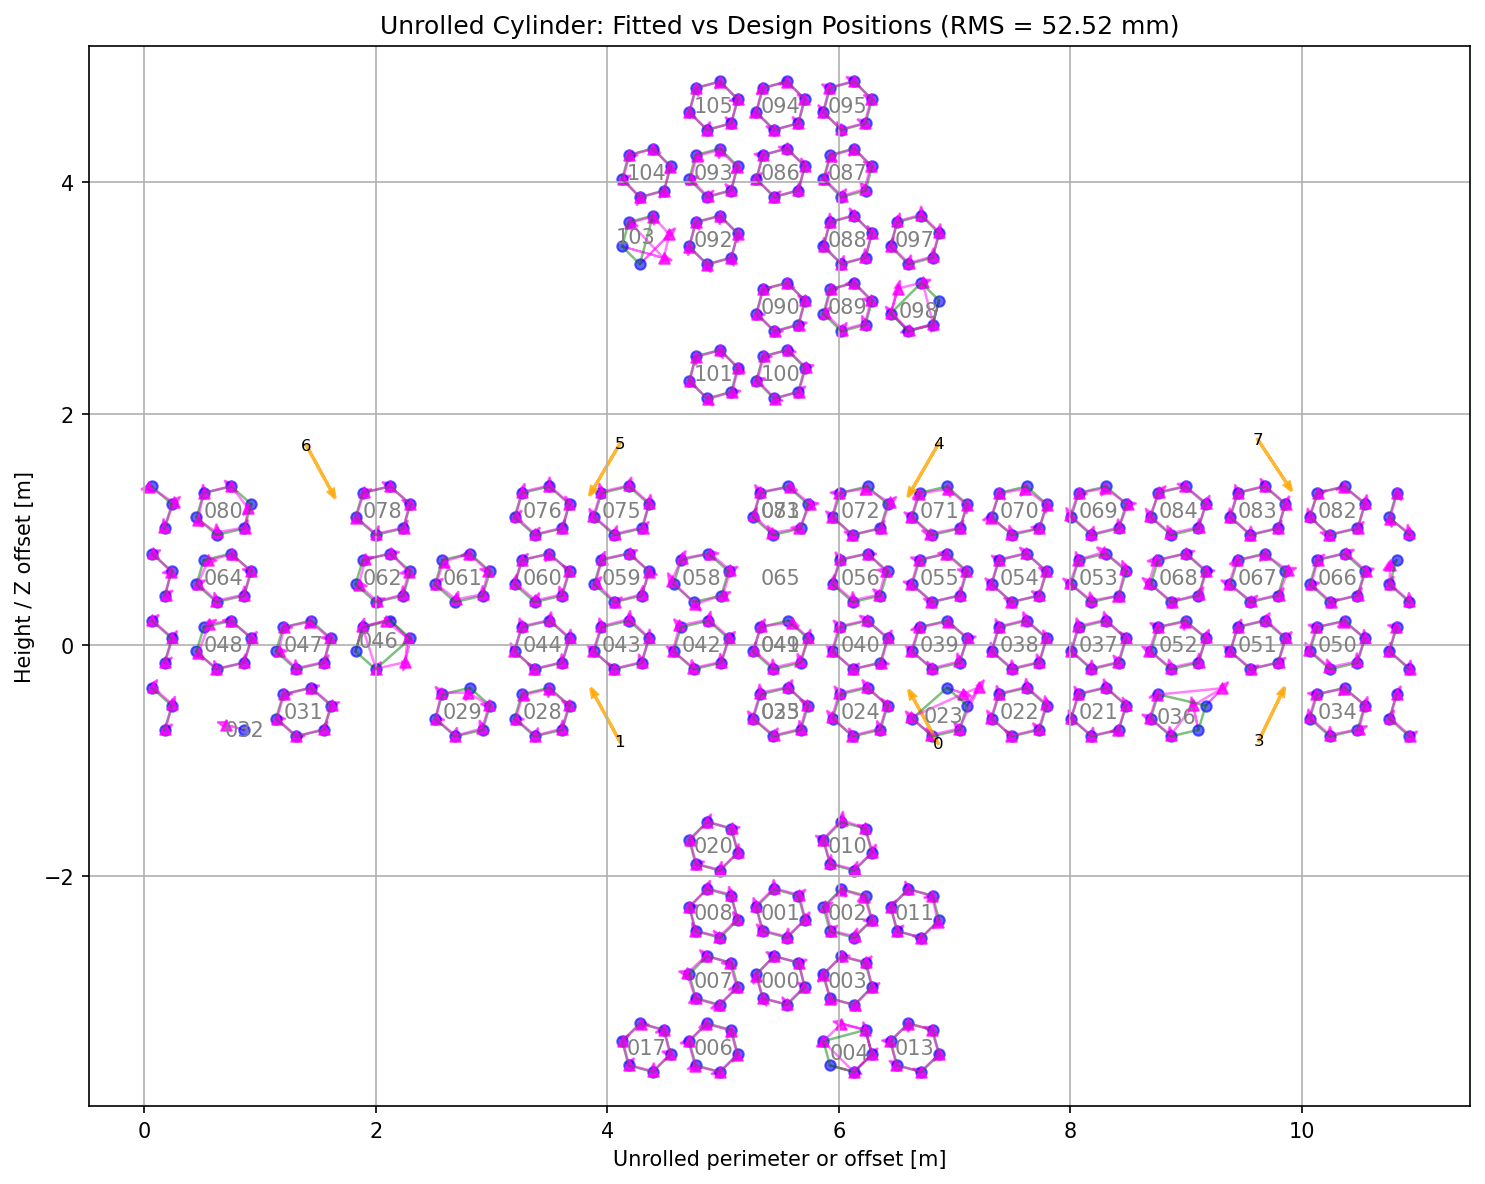

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Cylinder parameters
radius = 3.5 / 2
yoffset = 2 * 1.6
ycenter = 0.3
xoffset = 2 * np.pi * radius / 2

# Extract coordinates
X = design_points[:,0]
Y = design_points[:,1]
Z = design_points[:,2]

# Identify top, bottom, and wall points
Y_top = Y.max()
Y_bottom = Y.min()
is_top = Y == Y_top
is_bottom = Y == Y_bottom
is_wall = ~(is_top | is_bottom)

# Mask for features that were fitted
fitted_mask = np.linalg.norm(diff, axis=1) > 0

# --- Map wall points to unrolled coordinates ---
phi_wall = np.arctan2(Z[is_wall], X[is_wall])
X_wall = (phi_wall + np.pi) / (2*np.pi) * (2*np.pi*radius)
Y_wall = Y[is_wall]
X_wall_fit = X_wall + diff[is_wall, 0]
Y_wall_fit = Y_wall + diff[is_wall, 1]

# --- Map top/bottom caps ---
X_top = X[is_top] + xoffset
Z_top = Z[is_top] + yoffset + ycenter
X_top_fit = X_top + diff[is_top, 0]
Z_top_fit = Z_top + diff[is_top, 2]

X_bottom = X[is_bottom] + xoffset
Z_bottom = Z[is_bottom] - yoffset + ycenter
X_bottom_fit = X_bottom + diff[is_bottom, 0]
Z_bottom_fit = Z_bottom + diff[is_bottom, 2]

# --- Group points by module with feature numbers ---
def parse_feature(label):
    return int(label.split('-')[1])

modules_design = defaultdict(list)
modules_fitted = defaultdict(list)
modules_labels = defaultdict(list)

for i, l in enumerate(labels):
    module = l.split('-')[0]

    # Determine which unrolled coords to use
    if is_wall[i]:
        coord = (X_wall[i - np.where(is_wall)[0][0]], Y_wall[i - np.where(is_wall)[0][0]])
        coord_fit = (X_wall_fit[i - np.where(is_wall)[0][0]], Y_wall_fit[i - np.where(is_wall)[0][0]])
    elif is_top[i]:
        coord = (X_top[i - np.where(is_top)[0][0]], Z_top[i - np.where(is_top)[0][0]])
        coord_fit = (X_top_fit[i - np.where(is_top)[0][0]], Z_top_fit[i - np.where(is_top)[0][0]])
    else:
        coord = (X_bottom[i - np.where(is_bottom)[0][0]], Z_bottom[i - np.where(is_bottom)[0][0]])
        coord_fit = (X_bottom_fit[i - np.where(is_bottom)[0][0]], Z_bottom_fit[i - np.where(is_bottom)[0][0]])

    # Only store coordinates if feature was fitted
    if fitted_mask[i]:
        modules_design[module].append(coord)
        modules_fitted[module].append(coord_fit)
        modules_labels[module].append(parse_feature(l))


# --- Compute deviation metrics ---
deviation_mm = np.linalg.norm(diff, axis=1) * 1000  # total magnitude (mm)
radial_dev = np.zeros(len(labels))

for i in range(len(labels)):
    if is_wall[i]:
        r_fit = np.linalg.norm(design_points[i,:,[0,2]] + diff[i,[0,2]])
        r_design = np.linalg.norm(design_points[i,[0,2]])
        radial_dev[i] = (r_fit - r_design) * 1000  # mm, +outward, -inward
    elif is_top[i] or is_bottom[i]:
        # Axial difference (out of plane = along cylinder axis)
        radial_dev[i] = diff[i,1] * 1000  # mm, +up (outward), -down (inward)
        
# --- Plot ---
plt.figure(figsize=(10,8), dpi=150)

# Draw arrows for fitted points
for i in range(len(labels)):
    if fitted_mask[i]:
        if is_wall[i]:
            x0, y0 = X_wall[i - np.where(is_wall)[0][0]], Y_wall[i - np.where(is_wall)[0][0]]
            dx, dy = X_wall_fit[i - np.where(is_wall)[0][0]] - x0, Y_wall_fit[i - np.where(is_wall)[0][0]] - y0
        elif is_top[i]:
            x0, y0 = X_top[i - np.where(is_top)[0][0]], Z_top[i - np.where(is_top)[0][0]]
            dx, dy = X_top_fit[i - np.where(is_top)[0][0]] - x0, Z_top_fit[i - np.where(is_top)[0][0]] - y0
        else:
            x0, y0 = X_bottom[i - np.where(is_bottom)[0][0]], Z_bottom[i - np.where(is_bottom)[0][0]]
            dx, dy = X_bottom_fit[i - np.where(is_bottom)[0][0]] - x0, Z_bottom_fit[i - np.where(is_bottom)[0][0]] - y0
        plt.arrow(x0, y0, dx, dy, color='magenta', head_width=0.05, alpha=0.6)

# Scatter fitted points
for i in range(len(labels)):
    if fitted_mask[i]:
        if is_wall[i]:
            x, y = X_wall[i - np.where(is_wall)[0][0]], Y_wall[i - np.where(is_wall)[0][0]]
            x_fit, y_fit = X_wall_fit[i - np.where(is_wall)[0][0]], Y_wall_fit[i - np.where(is_wall)[0][0]]
        elif is_top[i]:
            x, y = X_top[i - np.where(is_top)[0][0]], Z_top[i - np.where(is_top)[0][0]]
            x_fit, y_fit = X_top_fit[i - np.where(is_top)[0][0]], Z_top_fit[i - np.where(is_top)[0][0]]
        else:
            x, y = X_bottom[i - np.where(is_bottom)[0][0]], Z_bottom[i - np.where(is_bottom)[0][0]]
            x_fit, y_fit = X_bottom_fit[i - np.where(is_bottom)[0][0]], Z_bottom_fit[i - np.where(is_bottom)[0][0]]
        plt.scatter(x, y, c='blue', s=25, alpha=0.6)
        plt.scatter(x_fit, y_fit, c='magenta', s=25, marker='^', alpha=0.8)

# --- Grey points for non-fitted features (unrolled) ---
non_fitted_mask = ~fitted_mask

# Separate wall, top, bottom for non-fitted
nf_wall = non_fitted_mask & is_wall
nf_top = non_fitted_mask & is_top
nf_bottom = non_fitted_mask & is_bottom

# Wall
phi_nf_wall = np.arctan2(Z[nf_wall], X[nf_wall])
X_nf_wall = (phi_nf_wall + np.pi) / (2*np.pi) * (2*np.pi*radius)
Y_nf_wall = Y[nf_wall]

# Top
X_nf_top = X[nf_top] + xoffset
Z_nf_top = Z[nf_top] + yoffset + ycenter

# Bottom
X_nf_bottom = X[nf_bottom] + xoffset
Z_nf_bottom = Z[nf_bottom] - yoffset + ycenter

# Plot grey non-fitted points
plt.scatter(X_nf_wall, Y_nf_wall, c='lightgrey', s=15, alpha=0.6)
plt.scatter(X_nf_top, Z_nf_top, c='lightgrey', s=15, alpha=0.6)
plt.scatter(X_nf_bottom, Z_nf_bottom, c='lightgrey', s=15, alpha=0.6)

def plot_module_lines_ordered(modules_coords, modules_labels, color, radius=3.5/2):
    """
    Plot module lines in order of feature number, closing the polygon,
    and avoid drawing lines across the cylinder unroll boundary.
    """
    for module, coords in modules_coords.items():
        coords = np.array(coords)
        labels_sorted = np.array(modules_labels[module])
        sort_idx = np.argsort(labels_sorted)
        pts_sorted = coords[sort_idx]

        # Close the polygon by appending the first point at the end
        pts_closed = np.vstack([pts_sorted, pts_sorted[0]])

        # Compute X differences between consecutive points
        diffs = np.abs(np.diff(pts_closed[:, 0]))
        
        # Identify indices where jump is too large (across cylinder cut)
        split_idx = np.where(diffs > np.pi * radius)[0]

        # Split polygon into safe segments
        segment_start = 0
        for idx in np.append(split_idx, len(pts_closed)-1):
            segment = pts_closed[segment_start:idx+1]
            if len(segment) > 1:  # only plot if at least 2 points
                plt.plot(segment[:,0], segment[:,1], color=color, lw=1.2, alpha=0.5)
            segment_start = idx+1


plot_module_lines_ordered(modules_design, modules_labels, 'green')
plot_module_lines_ordered(modules_fitted, modules_labels, 'magenta')

# Create dictionaries for non-fitted design points
modules_design_unfitted = defaultdict(list)
modules_labels_unfitted = defaultdict(list)

# Iterate through all labels and mark points with zero movement (not fitted)
for i, l in enumerate(labels):
    module = l.split('-')[0]
    # If diff is essentially zero, mark as non-fitted
    if np.linalg.norm(diff[i]) < 1e-8:  # threshold for unfitted
        # Determine which unrolled coords to use
        if is_wall[i]:
            coord = (X_wall[i - np.where(is_wall)[0][0]], Y_wall[i - np.where(is_wall)[0][0]])
        elif is_top[i]:
            coord = (X_top[i - np.where(is_top)[0][0]], Z_top[i - np.where(is_top)[0][0]])
        else:
            coord = (X_bottom[i - np.where(is_bottom)[0][0]], Z_bottom[i - np.where(is_bottom)[0][0]])
        modules_design_unfitted[module].append(coord)
        modules_labels_unfitted[module].append(parse_feature(l))

# Plot non-fitted design modules in grey
plot_module_lines_ordered(modules_design_unfitted, modules_labels_unfitted, color='grey', radius=radius)

# --- Add module numbers at centroid of design points ---
for module, coords in modules_design.items():
    coords = np.array(coords)
    centroid_x = coords[:,0].mean()
    centroid_y = coords[:,1].mean()
    plt.text(centroid_x, centroid_y, module, color='grey', fontsize=10, ha='center', va='center')

# --- Overlay camera positions and pointing directions on unrolled plot ---
cam_data = ba_results['cameras']  # your fitted camera extrinsics
# Each entry: {'rvec': [...], 'tvec': [...], 'n_observations': int}
arrow_length = 0.5  # adjust as needed
for cam_key in cam_data.keys():
    # Fitted camera
    tvec_fit = np.array(cam_data[cam_key]['tvec'])
    rvec_fit = np.array(cam_data[cam_key]['rvec'])
    dir_fit = rvec_to_direction(rvec_fit)

    # Map camera to unrolled coordinates
    # Same logic as for wall points
    x, y, z = tvec_fit
    if np.isclose(y, Y_top):
        X_cam = x + xoffset
        Y_cam = z + yoffset + ycenter
    elif np.isclose(y, Y_bottom):
        X_cam = x + xoffset
        Y_cam = z - yoffset + ycenter
    else:
        phi = np.arctan2(z, x)
        X_cam = (phi + np.pi)/(2*np.pi)*(2*np.pi*radius)
        Y_cam = y

    # Arrow in unrolled plane (projected)
    # Use X_cam,Y_cam as base, arrow in X/Y plane for simplicity
    dx = dir_fit[0]*arrow_length
    dy = dir_fit[1]*arrow_length
    plt.arrow(X_cam, Y_cam, dx, dy, color='orange', head_width=0.05, alpha=0.8, lw=1.5)

    # Optional label
    plt.text(X_cam, Y_cam, cam_key, color='black', fontsize=8, ha='center', va='center')


plt.xlabel("Unrolled perimeter or offset [m]")
plt.ylabel("Height / Z offset [m]")
plt.title(f"Unrolled Cylinder: Fitted vs Design Positions (RMS = {rms*1000:.2f} mm)")
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.savefig('wcte_3d_fit_result_07102025.png',facecolor='white')
plt.savefig('wcte_3d_fit_result_07102025.pdf',facecolor='white')
plt.show()


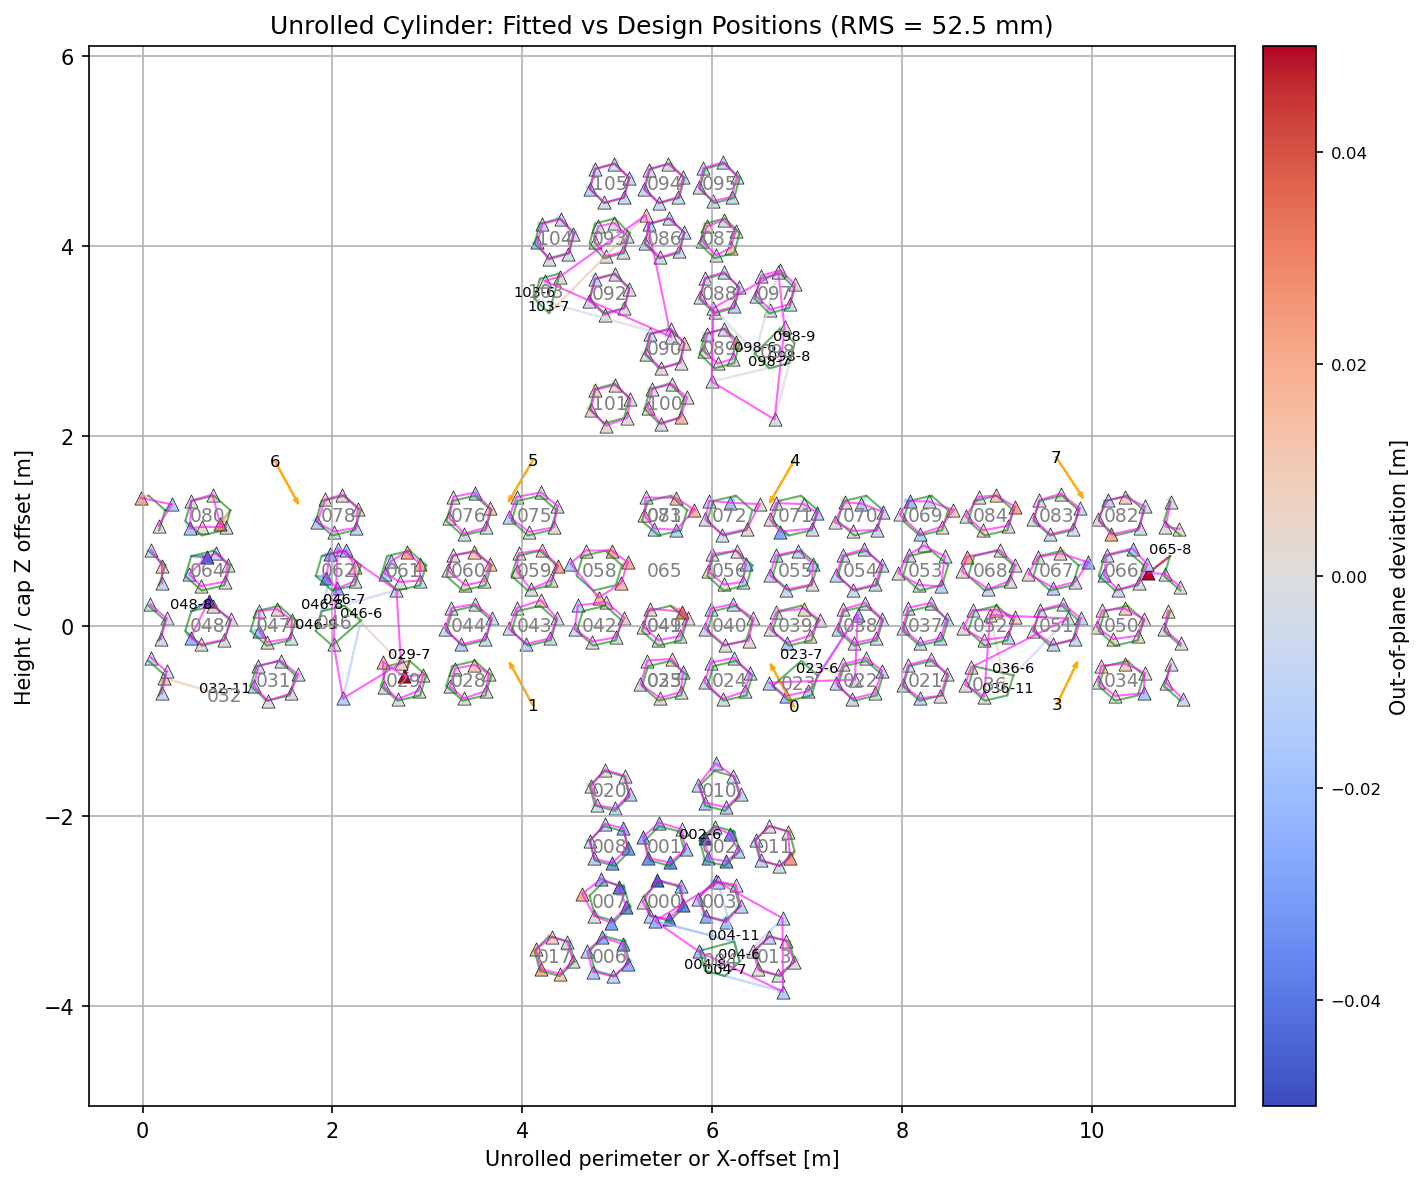

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib as mpl

# ---------------------------
# PARAMETERS (tweak if needed)
# ---------------------------
radius = 3.5 / 2        # cylinder radius [m]
yoffset = 2 * 1.6       # offset used in your unroll (m)
ycenter = 0.3           # center offset (m)
xoffset = 2 * np.pi * radius / 2
label_threshold_m = 0.05    # label points with >50 mm movement
exaggerate_inplane = 4.0   # exaggeration factor for in-plane display
color_range_mm = 50         # color scale +/- (mm)

# ---------------------------
# Basic arrays (from your session)
# ---------------------------
X = design_points[:, 0]
Y = design_points[:, 1]
Z = design_points[:, 2]

# classify top / bottom / wall using exact top/bottom y values
Y_top = Y.max()
Y_bottom = Y.min()
is_top = np.isclose(Y, Y_top)
is_bottom = np.isclose(Y, Y_bottom)
is_wall = ~(is_top | is_bottom)

# mask for points that moved (i.e., were fitted)
fitted_mask = np.linalg.norm(diff, axis=1) > 0

# --- Compute per-feature out-of-plane displacement (meters) ---
out_of_plane = np.zeros(len(X), dtype=float)
for i in range(len(X)):
    if is_wall[i]:
        r_fit = np.sqrt((X[i] + diff[i, 0])**2 + (Z[i] + diff[i, 2])**2)
        r_design = np.sqrt(X[i]**2 + Z[i]**2)
        out_of_plane[i] = r_fit - r_design     # + => outward, - => inward
    else:
        # for top/bottom, "out-of-plane" = movement along Y (vertical)
        out_of_plane[i] = diff[i, 1]

# --- Colors: map out_of_plane (m) -> color (coolwarm) clipped at ±color_range_mm ---
cmap = plt.cm.coolwarm
vmin = -color_range_mm / 1000.0
vmax = color_range_mm / 1000.0
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
colors = [cmap(norm(v)) for v in out_of_plane]

# --- Unrolled coordinates for wall and caps (design and fitted) ---
# Wall (unroll azimuth phi -> X_wall; keep Y as height)
phi_wall = np.arctan2(Z[is_wall], X[is_wall])
X_wall = (phi_wall + np.pi) / (2 * np.pi) * (2 * np.pi * radius)
Y_wall = Y[is_wall]
# exaggerate in-plane (X,Y) displacement for display
X_wall_fit = X_wall + exaggerate_inplane * diff[is_wall, 0]
Y_wall_fit = Y_wall + exaggerate_inplane * diff[is_wall, 1]

# Top cap
X_top = X[is_top] + xoffset
Z_top = Z[is_top] + yoffset + ycenter
X_top_fit = X_top + exaggerate_inplane * diff[is_top, 0]
Z_top_fit = Z_top + exaggerate_inplane * diff[is_top, 2]

# Bottom cap
X_bottom = X[is_bottom] + xoffset
Z_bottom = Z[is_bottom] - yoffset + ycenter
X_bottom_fit = X_bottom + exaggerate_inplane * diff[is_bottom, 0]
Z_bottom_fit = Z_bottom + exaggerate_inplane * diff[is_bottom, 2]

# --- Group points by module for drawing module outlines ---
def parse_feature(label):
    return int(label.split('-')[1])

modules_design = defaultdict(list)
modules_fitted = defaultdict(list)
modules_labels = defaultdict(list)

# create index lists for convenience
idx_wall = np.where(is_wall)[0]
idx_top = np.where(is_top)[0]
idx_bottom = np.where(is_bottom)[0]

for i, lab in enumerate(labels):
    module = lab.split('-')[0]
    if is_wall[i]:
        local_idx = int(np.where(idx_wall == i)[0][0])  # position inside wall arrays
        coord = (X_wall[local_idx], Y_wall[local_idx])
        coord_fit = (X_wall_fit[local_idx], Y_wall_fit[local_idx])
    elif is_top[i]:
        local_idx = int(np.where(idx_top == i)[0][0])
        coord = (X_top[local_idx], Z_top[local_idx])
        coord_fit = (X_top_fit[local_idx], Z_top_fit[local_idx])
    else:
        local_idx = int(np.where(idx_bottom == i)[0][0])
        coord = (X_bottom[local_idx], Z_bottom[local_idx])
        coord_fit = (X_bottom_fit[local_idx], Z_bottom_fit[local_idx])

    if fitted_mask[i]:
        modules_design[module].append(coord)
        modules_fitted[module].append(coord_fit)
        modules_labels[module].append(parse_feature(lab))

# --- Start plotting ---
fig, ax = plt.subplots(figsize=(10, 8), dpi=150)

# Draw arrows and fitted points
for i in range(len(labels)):
    if not fitted_mask[i]:
        continue
    color = colors[i]
    # pick appropriate coordinates depending on region
    if is_wall[i]:
        local_idx = int(np.where(idx_wall == i)[0][0])
        x0, y0 = X_wall[local_idx], Y_wall[local_idx]
        x1, y1 = X_wall_fit[local_idx], Y_wall_fit[local_idx]
    elif is_top[i]:
        local_idx = int(np.where(idx_top == i)[0][0])
        x0, y0 = X_top[local_idx], Z_top[local_idx]
        x1, y1 = X_top_fit[local_idx], Z_top_fit[local_idx]
    else:
        local_idx = int(np.where(idx_bottom == i)[0][0])
        x0, y0 = X_bottom[local_idx], Z_bottom[local_idx]
        x1, y1 = X_bottom_fit[local_idx], Z_bottom_fit[local_idx]

    dx, dy = (x1 - x0), (y1 - y0)
    # arrow (exaggerated draw uses dx,dy already scaled)
    ax.arrow(x0, y0, dx, dy, color=color, head_width=0.03, alpha=0.7, length_includes_head=True)
    ax.scatter(x1, y1, c=[color], s=40, marker='^', edgecolor='k', linewidths=0.3)

    # Label only if total movement magnitude > threshold (m)
    if np.linalg.norm(diff[i]) > label_threshold_m:
        ax.text(x0, y0, labels[i], fontsize=7, color='black', ha='center', va='bottom')

# Non-fitted features in light grey
non_fitted_mask = ~fitted_mask
nf_wall = non_fitted_mask & is_wall
nf_top = non_fitted_mask & is_top
nf_bottom = non_fitted_mask & is_bottom

phi_nf_wall = np.arctan2(Z[nf_wall], X[nf_wall])
X_nf_wall = (phi_nf_wall + np.pi) / (2 * np.pi) * (2 * np.pi * radius)
Y_nf_wall = Y[nf_wall]
X_nf_top = X[nf_top] + xoffset
Z_nf_top = Z[nf_top] + yoffset + ycenter
X_nf_bottom = X[nf_bottom] + xoffset
Z_nf_bottom = Z[nf_bottom] - yoffset + ycenter

ax.scatter(X_nf_wall, Y_nf_wall, c='lightgrey', s=15, alpha=0.6)
ax.scatter(X_nf_top, Z_nf_top, c='lightgrey', s=15, alpha=0.6)
ax.scatter(X_nf_bottom, Z_nf_bottom, c='lightgrey', s=15, alpha=0.6)

# --- Helper to draw module polygons without crossing the unroll seam ---
def plot_module_lines_ordered(modules_coords, modules_labels, color, radius=3.5/2):
    for module, coords in modules_coords.items():
        coords = np.array(coords)
        labels_sorted = np.array(modules_labels[module])
        sort_idx = np.argsort(labels_sorted)
        pts_sorted = coords[sort_idx]
        if pts_sorted.shape[0] < 2:
            continue
        pts_closed = np.vstack([pts_sorted, pts_sorted[0]])
        diffs = np.abs(np.diff(pts_closed[:, 0]))
        split_idx = np.where(diffs > np.pi * radius)[0]
        segment_start = 0
        for idx in np.append(split_idx, len(pts_closed) - 1):
            segment = pts_closed[segment_start:idx + 1]
            if len(segment) > 1:
                ax.plot(segment[:, 0], segment[:, 1], color=color, lw=1.0, alpha=0.6)
            segment_start = idx + 1

plot_module_lines_ordered(modules_design, modules_labels, 'green')
plot_module_lines_ordered(modules_fitted, modules_labels, 'magenta')

# --- Colorbar: make a ScalarMappable from the same norm and cmap used earlier ---
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])   # required for colorbar creation
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Out-of-plane deviation [m]')
cbar.ax.tick_params(labelsize=8)

# --- Module centroids (text) ---
for module, coords in modules_design.items():
    coords = np.array(coords)
    if coords.size == 0:
        continue
    centroid_x = coords[:, 0].mean()
    centroid_y = coords[:, 1].mean()
    ax.text(centroid_x, centroid_y, module, color='grey', fontsize=9, ha='center', va='center')

# --- Overlay camera arrows if ba_results present (optional) ---
# Handle camera_params saved as either list or dict
if 'cameras' in globals() or ('ba_results' in globals() and ba_results.get('cameras') is not None):
    cam_dict = ba_results['cameras'] if 'ba_results' in globals() else cameras
    # if cam_dict is a list (sparse), convert to index-keyed dict
    if isinstance(cam_dict, list):
        cam_map = {}
        # assume the list order corresponds to cam keys in cam_keys_sorted - you must adapt if not
        for idx, entry in enumerate(cam_dict):
            cam_map[idx] = entry
    else:
        cam_map = dict(cam_dict)

    arrow_length = 0.5
    for cam_key, cinfo in cam_map.items():
        tvec_fit = np.array(cinfo['tvec'])
        rvec_fit = np.array(cinfo['rvec'])
        # point camera into unrolled plane (approx): same mapping as points
        x, y, z = tvec_fit
        if np.isclose(y, Y_top):
            X_cam = x + xoffset
            Y_cam_p = z + yoffset + ycenter
        elif np.isclose(y, Y_bottom):
            X_cam = x + xoffset
            Y_cam_p = z - yoffset + ycenter
        else:
            phi = np.arctan2(z, x)
            X_cam = (phi + np.pi) / (2 * np.pi) * (2 * np.pi * radius)
            Y_cam_p = y
        # simple direction vector from rvec — convert to unit direction along camera forward axis
        # if you have rvec_to_direction function, use it; otherwise approximate:
        try:
            dir_fit = rvec_to_direction(rvec_fit)  # user-provided helper
        except Exception:
            # fallback: use small-angle approx: point along z-axis of camera frame
            dir_fit = np.array([0.0, 0.0, 1.0])
        dx = dir_fit[0] * arrow_length
        dy = dir_fit[1] * arrow_length
        ax.arrow(X_cam, Y_cam_p, dx, dy, color='orange', head_width=0.04, alpha=0.9)
        ax.text(X_cam, Y_cam_p, str(cam_key), fontsize=8, ha='center', va='center')

# final touches
ax.set_xlabel("Unrolled perimeter or X-offset [m]")
ax.set_ylabel("Height / cap Z offset [m]")
ax.set_title(f"Unrolled Cylinder: Fitted vs Design Positions (RMS = {rms*1000:.1f} mm)")
ax.set_aspect('equal', adjustable='datalim')
ax.grid(True)
plt.tight_layout()
plt.savefig('wcte_3d_fit_result_colored.png', facecolor='white', dpi=200)
plt.show()


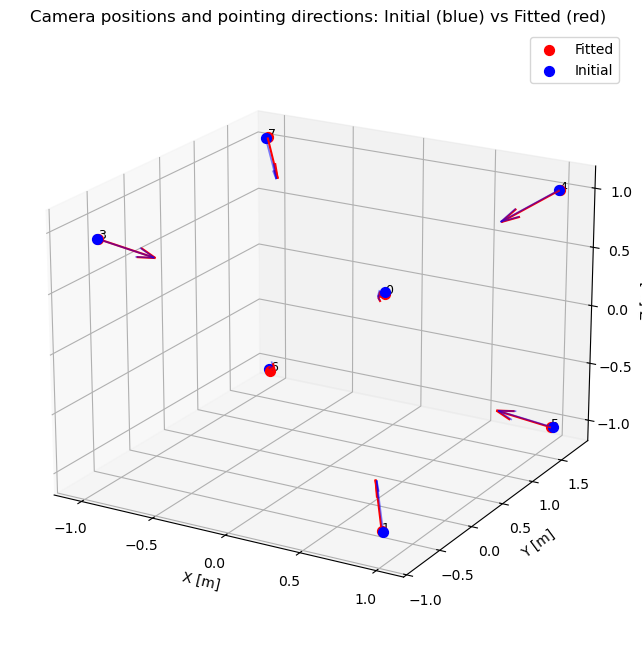

In [33]:
# --- Mapping of cam_data keys to list indices in camera_params ---
cam_index_map = {0: 0, 1: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}

# --- Plot setup ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for cam_key, cam_info in cam_data.items():
    # Fitted
    tvec_fit = np.array(cam_info['tvec'])
    rvec_fit = np.array(cam_info['rvec'])
    dir_fit = rvec_to_direction(rvec_fit)
    
    # Initial (from list)
    idx = cam_index_map[cam_key]
    rvec_init, tvec_init = camera_params[idx]
    rvec_init = np.array(rvec_init).flatten()
    tvec_init = np.array(tvec_init).flatten()
    dir_init = rvec_to_direction(rvec_init)
    
    # Scatter points
    ax.scatter(*tvec_fit, color='red', s=50, label='Fitted' if cam_key==0 else "")
    ax.scatter(*tvec_init, color='blue', s=50, label='Initial' if cam_key==0 else "")
    
    # Connect initial→fitted with a line
    ax.plot([tvec_init[0], tvec_fit[0]],
            [tvec_init[1], tvec_fit[1]],
            [tvec_init[2], tvec_fit[2]],
            color='gray', linestyle='--', alpha=0.6)
    
    # Direction arrows
    arrow_length = 0.5
    ax.quiver(*tvec_fit, *(dir_fit*arrow_length), color='red', linewidth=1.5)
    ax.quiver(*tvec_init, *(dir_init*arrow_length), color='blue', linewidth=1.2, alpha=0.5)
    
    # Label cameras
    ax.text(*tvec_fit, f"{cam_key}", color='black', fontsize=9)

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.set_title("Camera positions and pointing directions: Initial (blue) vs Fitted (red)")
ax.legend()
ax.grid(True)
ax.view_init(elev=20, azim=-60)

plt.show()









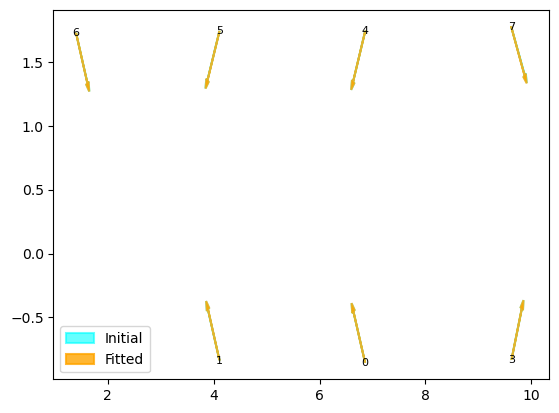

In [34]:
# --- Overlay camera pointing directions on unrolled plot ---
arrow_length = 0.5  # length of arrow in meters

for cam_idx, (rvec_init, tvec_init) in enumerate(camera_params):
    # Fitted camera from bundle adjustment
    cam_key = list(ba_results['cameras'].keys())[cam_idx]
    rvec_fit = np.array(ba_results['cameras'][cam_key]['rvec'])
    tvec_fit = np.array(ba_results['cameras'][cam_key]['tvec'])

    # Convert Rodrigues to unit direction vectors
    dir_init = rvec_to_direction(rvec_init)
    dir_fit  = rvec_to_direction(rvec_fit)

    # Map camera position to unrolled coordinates
    x, y, z = tvec_fit
    if np.isclose(y, Y_top):
        X_cam = x + xoffset
        Y_cam = z + yoffset + ycenter
    elif np.isclose(y, Y_bottom):
        X_cam = x + xoffset
        Y_cam = z - yoffset + ycenter
    else:
        phi = np.arctan2(z, x)
        X_cam = (phi + np.pi)/(2*np.pi)*(2*np.pi*radius)
        Y_cam = y

    # Draw initial camera pointing (cyan)
    plt.arrow(X_cam, Y_cam, dir_init[0]*arrow_length, dir_init[1]*arrow_length,
              color='cyan', head_width=0.05, alpha=0.6, lw=1.5, label='Initial' if cam_idx==0 else None)

    # Draw fitted camera pointing (orange)
    plt.arrow(X_cam, Y_cam, dir_fit[0]*arrow_length, dir_fit[1]*arrow_length,
              color='orange', head_width=0.05, alpha=0.8, lw=1.5, label='Fitted' if cam_idx==0 else None)

    # Optional label
    plt.text(X_cam, Y_cam, cam_key, fontsize=8, ha='center', va='center')

# Add legend for arrows
plt.legend()


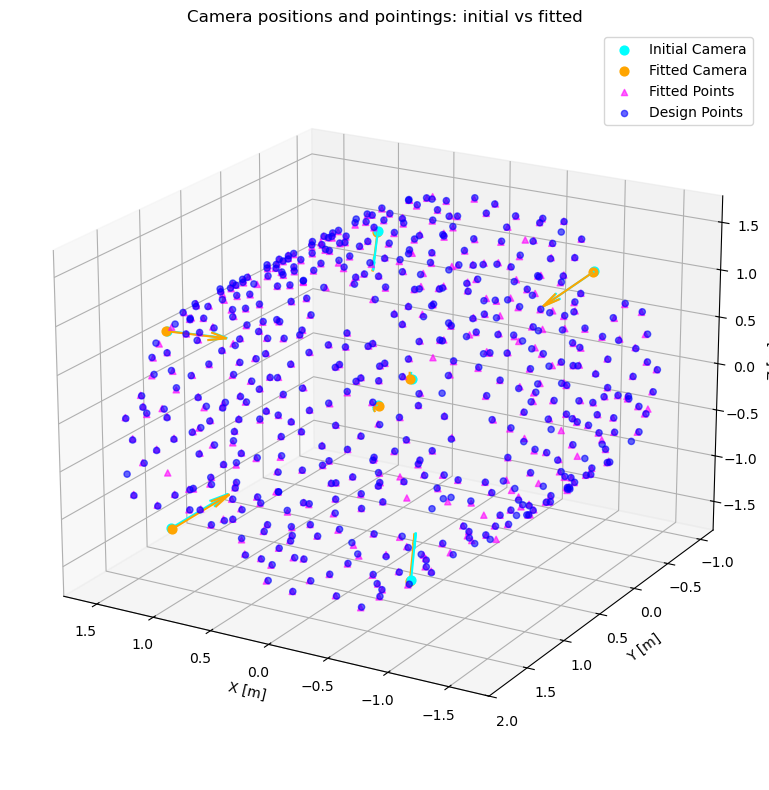

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Helper: Rodrigues vector -> unit direction vector
def rvec_to_direction(rvec):
    R_mat, _ = cv2.Rodrigues(rvec)
    return R_mat @ np.array([0,0,1])  # optical axis points along z

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

arrow_length = 0.5  # meters

for cam_idx, (rvec_init, tvec_init) in enumerate(camera_params):
    # Fitted camera
    cam_key = list(ba_results['cameras'].keys())[cam_idx]
    rvec_fit = np.array(ba_results['cameras'][cam_key]['rvec'])
    tvec_fit = np.array(ba_results['cameras'][cam_key]['tvec'])

    # Camera directions
    dir_init = rvec_to_direction(rvec_init)
    dir_fit  = rvec_to_direction(rvec_fit)

    # Plot camera positions
    ax.scatter(*tvec_init, c='cyan', s=40, label='Initial Camera' if cam_idx==0 else None)
    ax.scatter(*tvec_fit, c='orange', s=40, label='Fitted Camera' if cam_idx==0 else None)

    # Plot pointing arrows
    ax.quiver(*tvec_init, *dir_init*arrow_length, color='cyan', length=arrow_length, normalize=True)
    ax.quiver(*tvec_fit, *dir_fit*arrow_length, color='orange', length=arrow_length, normalize=True)

# Optional: also plot fitted points
ax.scatter(fitted_points[:,0], fitted_points[:,1], fitted_points[:,2],
           c='magenta', s=20, marker='^', alpha=0.6, label='Fitted Points')
ax.scatter(design_points[:,0], design_points[:,1], design_points[:,2],
           c='blue', s=20, alpha=0.6, label='Design Points')

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.set_title("Camera positions and pointings: initial vs fitted")
ax.legend()
ax.grid(True)
ax.view_init(elev=20, azim=120)  # adjust for a good view
plt.tight_layout()
plt.show()
